# Preparing for work

In [1]:
!pip install tensorboard torch
!pip install huggingface-hub==0.10.1
!pip install scikit-learn datasets evaluate
!pip install transformers==4.28.0

  Using cached huggingface_hub-0.10.1-py3-none-any.whl (163 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.1
    Uninstalling huggingface-hub-0.17.1:
      Successfully uninstalled huggingface-hub-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.5 requires huggingface-hub<1.0.0,>=0.14.0, but you have huggingface-hub 0.10.1 which is incompatible.
transformers 4.28.0 requires huggingface-hub<1.0,>=0.11.0, but you have huggingface-hub 0.10.1 which is incompatible.
  Using cached huggingface_hub-0.17.1-py3-none-any.whl (294 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1


In [2]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score

import transformers
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

# Dataset analysis

In [3]:
df = pd.read_csv("/content/train_2K.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        2037 non-null   object
 1   Corrective  2037 non-null   int64 
 2   Adaptive    2037 non-null   int64 
 3   Perfective  2037 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 63.8+ KB


In [4]:
df.head()

,text,Corrective,Adaptive,Perfective
0,netfilter: xt_log: fix mark logging for ip...,1,0,0
1,[patch] inode-diet: eliminate i_blksize fr...,1,0,0
2,tensor roll op implementation (#14953) ...,1,1,0
3,improve video updates from sheet,0,0,1
4,[spark-9372] [sql] filter nulls in join ke...,0,0,1


Let's look at the number of commits with different labels

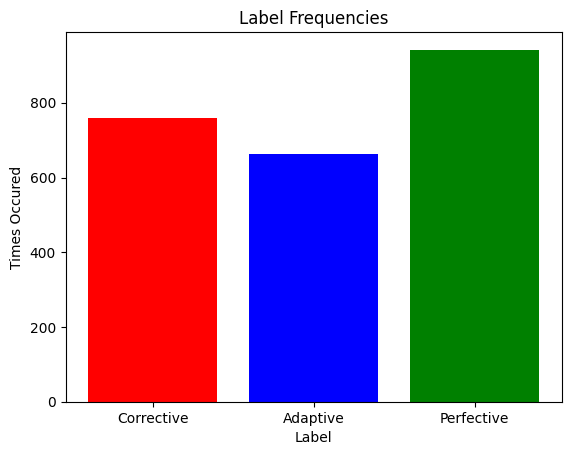

In [5]:
number_of_labels = pd.DataFrame({
    'Corrective': df['Corrective'],
    'Adaptive': df['Adaptive'],
    'Perfective': df['Perfective']
})

labels = number_of_labels.keys()
frequencies = [sum(number_of_labels['Corrective']), sum(number_of_labels['Adaptive']), sum(number_of_labels['Perfective'])]

plt.bar(labels, frequencies, color=['red', 'blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Times Occured')
plt.title('Label Frequencies')
plt.show()

Also let's remove unlabeled commit from our training data like it was made in the paper

In [6]:
indexes_to_drop = []
for i in range(len(number_of_labels.index)):
    if not number_of_labels.iloc[i].any():
        print(i)
        indexes_to_drop.append(i)
        continue

df = df.drop(labels=indexes_to_drop, axis=0)
df.shape

242
465


(2035, 4)

Also let's look at the numbers of combinations of commits labels in our training data

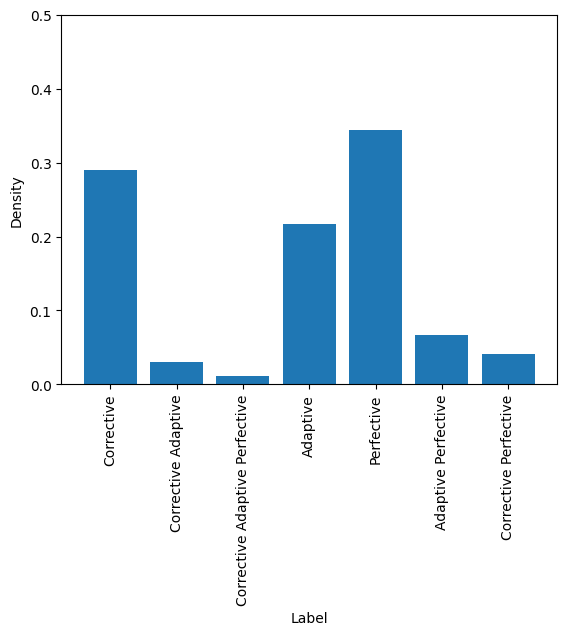

In [7]:
numbers_of_different_labels = {'Corrective': 0, 'Corrective Adaptive': 0, 'Corrective Adaptive Perfective': 0,
                'Adaptive': 0, 'Perfective': 0, 'Adaptive Perfective': 0,
                'Corrective Perfective': 0, '':0}

for i in range(len(number_of_labels.index)):
    label = ''
    if number_of_labels.iloc[i].Corrective:
        label += 'Corrective '
    if number_of_labels.iloc[i].Adaptive:
        label += 'Adaptive '
    if number_of_labels.iloc[i].Perfective:
        label += 'Perfective '

    label = label.strip()
    numbers_of_different_labels[label] += 1

total_number = sum(numbers_of_different_labels.values())
numbers_of_different_labels = {k: v / total_number for k, v in numbers_of_different_labels.items() if k}


plt.bar(list(numbers_of_different_labels.keys()), list(numbers_of_different_labels.values()))
plt.xlabel('Label')
plt.ylabel('Density')
plt.ylim(0.0, 0.5)
plt.xticks(rotation=90)
plt.show()

# Dataset preparation

Let's spleet our data for train and evaluate datasets

In [8]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.85)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'eval' : train_testEval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (1729, 5)
Evaluation Dataset Shape: (306, 5)


Let's prepare list of labels and dictionares for converting between string and integer representation of label for subsequent model training


In [9]:
labels = [x for x in df.columns if x not in ['text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
NUM_OF_LABELS = len(labels)
print(labels)
print(id2label)
print(label2id)

['Corrective', 'Adaptive', 'Perfective']
{0: 'Corrective', 1: 'Adaptive', 2: 'Perfective'}
{'Corrective': 0, 'Adaptive': 1, 'Perfective': 2}


Let's define the parameters of our model. I use parameters from the article.

In [10]:
set_seed = 42
NUM_OF_EPOCHS = 4

BATCH_SIZE = 8
LEARNING_RATE = 2e-5

MAX_LENGTH = 512
MODEL_CKPT = "distilbert-base-uncased"
MODEL_NAME = MODEL_CKPT + "-commits-review"

METRIC_NAME = "f1"
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f'Using GPU : {torch.cuda.get_device_name(0)}')
else:
    DEVICE = torch.device("cpu")
    print(f'Using CPU')

Using GPU : Tesla T4


Let's create Tokenizer and the necessary data preparation for it

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def data_preprocessor(examples):
	text = examples["text"]
	encoded_data = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
	labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
	labels_matrix = np.zeros((len(text), len(labels)))
	for idx, label in enumerate(labels):
		labels_matrix[:, idx] = labels_batch[label]

	encoded_data["labels"] = labels_matrix.tolist()

	return encoded_data

Tokenization of our set

In [12]:
encoded_ds = ds.map(data_preprocessor, batched=True, load_from_cache_file=False)
encoded_ds.set_format("torch")

Map:   0%|          | 0/1729 [00:00<?, ? examples/s]

Map:   0%|          | 0/306 [00:00<?, ? examples/s]

Let's make sure that tokenization was ok

In [13]:
print(f"The shape of the training dataset is: {encoded_ds['train'].shape}")
print(f"The shape of the evaluation dataset is: {encoded_ds['eval'].shape}")

The shape of the training dataset is: (1729, 8)
The shape of the evaluation dataset is: (306, 8)


# Model training and estimation on hyperparameters from the paper

Let's define our model

In [14]:
from transformers import DistilBertForSequenceClassification
model = (DistilBertForSequenceClassification.from_pretrained(MODEL_CKPT,
                                                             num_labels=NUM_OF_LABELS,
                                                             problem_type="multi_label_classification",
                                                             id2label=id2label,
                                                             label2id=label2id)
         ).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Let's define evaluation metrics for our model. We use metrics like in the paper.

In [15]:
def multi_label_metrics(predictions,
                        labels,
                        threshold=0.5):

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'accuracy': accuracy}
    return metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    preds = preds[0] if isinstance(preds,
                    tuple) else preds
    results = multi_label_metrics(
                    predictions=preds,
                    labels=labels)
    return results

Let's define training parameters for our model

In [16]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
    greater_is_better=True,
    disable_tqdm=False,

    logging_first_step=False,
    hub_private_repo=False,
    push_to_hub=False
)

Let's finally instantiate our Trainer

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Let's train our model

In [18]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.344326,0.824405,0.732026
2,No log,0.324417,0.834320,0.741830
3,0.350900,0.319869,0.842415,0.748366
4,0.350900,0.317626,0.842105,0.745098


TrainOutput(global_step=868, training_loss=0.28601473267726635, metrics={'train_runtime': 384.416, 'train_samples_per_second': 17.991, 'train_steps_per_second': 2.258, 'total_flos': 916160867241984.0, 'train_loss': 0.28601473267726635, 'epoch': 4.0})

As we can see in the report after training, training loss is not high and all other metrics are not bad, therefore we can assume that our model will work well in the general case.

Let's evaluate our model.

In [19]:
trainer.evaluate()

{'eval_loss': 0.3198694586753845,
 'eval_f1': 0.8424153166421207,
 'eval_accuracy': 0.7483660130718954,
 'eval_runtime': 4.8467,
 'eval_samples_per_second': 63.136,
 'eval_steps_per_second': 8.047,
 'epoch': 4.0}

We can see that our model evaluate metrics are not bad too.

But maybe if we find better hyperparameters our model will be better. Let's check this assumption.

# Search for more suitable hyperparameters

In [20]:
def model_init():
    return DistilBertForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=NUM_OF_LABELS, problem_type="multi_label_classification",
        id2label=id2label, label2id=label2id)


In [21]:
!pip install ray[tune]

In [22]:
from ray import tune
def ray_hp_space(trial):
    return {
        "learning_rate": tune.uniform(1e-5, 5e-5),
        "num_train_epochs": tune.choice([4, 5, 6]),
        "per_device_train_batch_size": tune.choice([8, 16]),
        "weight_decay": tune.uniform(0.0, 0.3)
    }

In [23]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model='f1',
    load_best_model_at_end=True,
)


In [24]:

trainer_search = Trainer(
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [25]:
best_run = trainer_search.hyperparameter_search(
    direction="maximize",
    backend="ray",
    n_trials=10,
    hp_space=ray_hp_space
)

2023-09-13 19:33:20,136	INFO worker.py:1621 -- Started a local Ray instance.
2023-09-13 19:33:28,066	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-09-13 19:33:28,193	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py:624: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/latest/tun

+-------------------------------------------------------------------+
| Configuration for experiment     _objective_2023-09-13_19-33-28   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 10                               |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/_objective_2023-09-13_19-33-28
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/_objective_2023-09-13_19-33-28`

Trial status: 10 PENDING
Current time: 2023-09-13 19:33:29. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_tra

(pid=10831) 2023-09-13 19:33:53.120361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00000 started with configuration:
+------------------------------------------------+
| Trial _objective_69f33_00000 config            |
+------------------------------------------------+
| learning_rate                            2e-05 |
| num_train_epochs                             4 |
| per_device_train_batch_size                  8 |
| weight_decay                            0.2196 |
+------------------------------------------------+

Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:33:59. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay |
+--------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING 

(_objective pid=10831) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
(_objective pid=10831) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=10831) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=10831) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:34:29. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay |
+--------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598   |
| _objective_69f33_00001   PENDING        3.39463e-05                    6                       16       0.0467984  |
| _objective_69f33_00002   PENDING        1.23233e-05                    4                       16       0.04286    |
| _objective_69f33_00003   PENDING        3.60355e-05                    4                       16       0.2166     |
| _objective_69f33_00

 15%|█▍        | 130/868 [00:48<04:31,  2.72it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:34:59. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay |
+--------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598   |
| _objective_69f33_00001   PENDING        3.39463e-05                    6                       16       0.0467984  |
| _objective_69f33_00002   PENDING        1.23233e-05                    4                       16       0.04286    |
| _objective_69f33_00003   PENDING        3.60355e-05                    4                       16       0.2166     |
| _objective_69f33_0

 24%|██▍       | 210/868 [01:18<03:59,  2.75it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:35:29. Total running time: 2min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+--------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay |
+--------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598   |
| _objective_69f33_00001   PENDING        3.39463e-05                    6                       16       0.0467984  |
| _objective_69f33_00002   PENDING        1.23233e-05                    4                       16       0.04286    |
| _objective_69f33_00003   PENDING        3.60355e-05                    4                       16       0.2166     |
| _objective_69f33_00

 25%|██▍       | 216/868 [01:20<03:55,  2.76it/s]
(_objective pid=10831) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=10831) 
  5%|▌         | 2/39 [00:00<00:02, 16.37it/s]
(_objective pid=10831) 
 10%|█         | 4/39 [00:00<00:03, 10.15it/s]
(_objective pid=10831) 
 15%|█▌        | 6/39 [00:00<00:04,  8.15it/s]
(_objective pid=10831) 
 18%|█▊        | 7/39 [00:02<00:13,  2.34it/s]
(_objective pid=10831) 
 21%|██        | 8/39 [00:02<00:12,  2.42it/s]
(_objective pid=10831) 
 23%|██▎       | 9/39 [00:02<00:12,  2.48it/s]
(_objective pid=10831) 
 26%|██▌       | 10/39 [00:04<00:18,  1.59it/s]
(_objective pid=10831) 
 28%|██▊       | 11/39 [00:04<00:15,  1.75it/s]
(_objective pid=10831) 
 31%|███       | 12/39 [00:04<00:11,  2.25it/s]
(_objective pid=10831) 
 33%|███▎      | 13/39 [00:04<00:09,  2.85it/s]
(_objective pid=10831) 
 36%|███▌      | 14/39 [00:04<00:07,  3.52it/s]
(_objective pid=10831) 
 38%|███▊      | 15/39 [00:05<00:05,  4.24it/s]
(_objective pid=10831) 
 41%|

Trial _objective_69f33_00000 finished iteration 1 at 2023-09-13 19:35:39. Total running time: 2min 10s
+-------------------------------------------------+
| Trial _objective_69f33_00000 result             |
+-------------------------------------------------+
| time_this_iter_s                         103.61 |
| time_total_s                             103.61 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.68627 |
| eval_f1                                 0.79118 |
| eval_loss                               0.37129 |
| eval_runtime                              8.055 |
| eval_samples_per_second                  37.989 |
| eval_steps_per_second                     4.842 |
| objective                               1.47745 |
+-------------------------------------------------+

(_objective pid=10831) {'eval_loss': 0.3712882697582245, 'eval_f1': 0.7911764705882351, 'eval_accuracy': 0.686274509

 30%|███       | 264/868 [01:48<03:40,  2.74it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:35:59. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          1             103.61       1.47745      0.371288    0.791176          0.686275 |
| _objective_69f33_00001   PENDIN

 40%|███▉      | 345/868 [02:18<03:13,  2.70it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:36:29. Total running time: 3min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          1             103.61       1.47745      0.371288    0.791176          0.686275 |
| _objective_69f33_00001   PENDING

 49%|████▉     | 427/868 [02:48<02:41,  2.74it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:36:59. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          1             103.61       1.47745      0.371288    0.791176          0.686275 |
| _objective_69f33_00001   PENDIN

 50%|████▉     | 433/868 [02:50<02:38,  2.74it/s]
(_objective pid=10831) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=10831) 
  5%|▌         | 2/39 [00:00<00:02, 15.92it/s]
(_objective pid=10831) 
 10%|█         | 4/39 [00:00<00:03,  9.86it/s]
(_objective pid=10831) 
 15%|█▌        | 6/39 [00:00<00:03,  8.86it/s]
(_objective pid=10831) 
 18%|█▊        | 7/39 [00:00<00:03,  8.62it/s]
(_objective pid=10831) 
 21%|██        | 8/39 [00:00<00:03,  8.46it/s]
(_objective pid=10831) 
 23%|██▎       | 9/39 [00:01<00:03,  8.30it/s]
(_objective pid=10831) 
 26%|██▌       | 10/39 [00:01<00:03,  8.19it/s]
(_objective pid=10831) 
 28%|██▊       | 11/39 [00:01<00:03,  8.12it/s]
(_objective pid=10831) 
 31%|███       | 12/39 [00:01<00:03,  8.09it/s]
(_objective pid=10831) 
 33%|███▎      | 13/39 [00:01<00:03,  8.03it/s]
(_objective pid=10831) 
 36%|███▌      | 14/39 [00:01<00:03,  7.97it/s]
(_objective pid=10831) 
 38%|███▊      | 15/39 [00:01<00:03,  7.93it/s]
(_objective pid=10831) 
 41%|

Trial _objective_69f33_00000 finished iteration 2 at 2023-09-13 19:37:06. Total running time: 3min 37s
+-------------------------------------------------+
| Trial _objective_69f33_00000 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.9871 |
| time_total_s                            190.597 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.73529 |
| eval_f1                                 0.83504 |
| eval_loss                                0.3117 |
| eval_runtime                             4.8417 |
| eval_samples_per_second                  63.201 |
| eval_steps_per_second                     8.055 |
| objective                               1.57033 |
+-------------------------------------------------+

(_objective pid=10831) {'eval_loss': 0.3117007911205292, 'eval_f1': 0.8350364963503649, 'eval_accuracy': 0.735294117

(_objective pid=10831) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.82it/s]
                                               
 56%|█████▋    | 489/868 [03:18<02:18,  2.74it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:37:29. Total running time: 4min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          2            190.597       1.57033      0.311701    0.835036          0.735294 |
| _objective_69f33_00001   PENDING

 58%|█████▊    | 500/868 [03:22<02:14,  2.74it/s]


(_objective pid=10831) {'loss': 0.3501, 'learning_rate': 1.0591279434830849e-05, 'epoch': 2.3}


 66%|██████▌   | 571/868 [03:48<01:48,  2.74it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:37:59. Total running time: 4min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          2            190.597       1.57033      0.311701    0.835036          0.735294 |
| _objective_69f33_00001   PENDIN

 75%|███████▍  | 650/868 [04:17<01:20,  2.72it/s]
(_objective pid=10831) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=10831) 
  5%|▌         | 2/39 [00:00<00:02, 15.71it/s]
(_objective pid=10831) 
 10%|█         | 4/39 [00:00<00:03,  9.93it/s]
(_objective pid=10831) 
 15%|█▌        | 6/39 [00:00<00:03,  8.86it/s]
(_objective pid=10831) 
 18%|█▊        | 7/39 [00:00<00:03,  8.58it/s]
(_objective pid=10831) 
 21%|██        | 8/39 [00:00<00:03,  8.44it/s]
(_objective pid=10831) 
 23%|██▎       | 9/39 [00:01<00:03,  8.25it/s]
(_objective pid=10831) 
 26%|██▌       | 10/39 [00:01<00:03,  8.07it/s]
(_objective pid=10831) 
 28%|██▊       | 11/39 [00:01<00:03,  8.00it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:38:29. Total running time: 5min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          2            190.597       1.57033      0.311701    0.835036          0.735294 |
| _objective_69f33_00001   PENDING

(_objective pid=10831) 
 31%|███       | 12/39 [00:01<00:03,  7.97it/s]
(_objective pid=10831) 
 33%|███▎      | 13/39 [00:01<00:03,  7.95it/s]
(_objective pid=10831) 
 36%|███▌      | 14/39 [00:01<00:03,  7.86it/s]
(_objective pid=10831) 
 38%|███▊      | 15/39 [00:01<00:03,  7.86it/s]
(_objective pid=10831) 
 41%|████      | 16/39 [00:01<00:02,  7.89it/s]
(_objective pid=10831) 
 44%|████▎     | 17/39 [00:02<00:02,  7.92it/s]
(_objective pid=10831) 
 46%|████▌     | 18/39 [00:02<00:02,  7.95it/s]
(_objective pid=10831) 
 49%|████▊     | 19/39 [00:02<00:02,  7.86it/s]
(_objective pid=10831) 
 51%|█████▏    | 20/39 [00:02<00:02,  7.82it/s]
(_objective pid=10831) 
 54%|█████▍    | 21/39 [00:02<00:02,  7.84it/s]
(_objective pid=10831) 
 56%|█████▋    | 22/39 [00:02<00:02,  7.85it/s]
(_objective pid=10831) 
 59%|█████▉    | 23/39 [00:02<00:02,  7.80it/s]
(_objective pid=10831) 
 62%|██████▏   | 24/39 [00:02<00:01,  7.87it/s]
(_objective pid=10831) 
 64%|██████▍   | 25/39 [00:03<00:01,  7.

Trial _objective_69f33_00000 finished iteration 3 at 2023-09-13 19:38:33. Total running time: 5min 4s
+-------------------------------------------------+
| Trial _objective_69f33_00000 result             |
+-------------------------------------------------+
| time_this_iter_s                         86.943 |
| time_total_s                             277.54 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.75817 |
| eval_f1                                 0.84919 |
| eval_loss                               0.31879 |
| eval_runtime                             4.8778 |
| eval_samples_per_second                  62.734 |
| eval_steps_per_second                     7.995 |
| objective                               1.60736 |
+-------------------------------------------------+

(_objective pid=10831) {'eval_loss': 0.31878867745399475, 'eval_f1': 0.849194729136164, 'eval_accuracy': 0.7581699346

 81%|████████  | 703/868 [04:49<01:00,  2.72it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:38:59. Total running time: 5min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          3             277.54       1.60736      0.318789    0.849195           0.75817 |
| _objective_69f33_00001   PENDIN

 90%|█████████ | 784/868 [05:19<00:30,  2.72it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:39:29. Total running time: 6min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          3             277.54       1.60736      0.318789    0.849195           0.75817 |
| _objective_69f33_00001   PENDING

100%|█████████▉| 867/868 [05:49<00:00,  2.74it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2023-09-13 19:40:00. Total running time: 6min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status       learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   RUNNING        2.49816e-05                    4                        8       0.219598          3             277.54       1.60736      0.318789    0.849195           0.75817 |
| _objective_69f33_00001   PENDIN

(_objective pid=10831) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=10831) 
  5%|▌         | 2/39 [00:00<00:02, 15.84it/s]
(_objective pid=10831) 
 10%|█         | 4/39 [00:00<00:03,  9.96it/s]
(_objective pid=10831) 
 15%|█▌        | 6/39 [00:00<00:03,  8.85it/s]
(_objective pid=10831) 
 18%|█▊        | 7/39 [00:00<00:03,  8.53it/s]
(_objective pid=10831) 
 21%|██        | 8/39 [00:00<00:03,  8.38it/s]
(_objective pid=10831) 
 23%|██▎       | 9/39 [00:01<00:03,  8.30it/s]
(_objective pid=10831) 
 26%|██▌       | 10/39 [00:01<00:03,  8.24it/s]
(_objective pid=10831) 
 28%|██▊       | 11/39 [00:01<00:03,  8.19it/s]
(_objective pid=10831) 
 31%|███       | 12/39 [00:01<00:03,  8.20it/s]
(_objective pid=10831) 
 33%|███▎      | 13/39 [00:01<00:03,  8.18it/s]
(_objective pid=10831) 
 36%|███▌      | 14/39 [00:01<00:03,  8.06it/s]
(_objective pid=10831) 
 38%|███▊      | 15/39 [00:01<00:03,  7.95it/s]
(_objective pid=10831) 
 41%|████      | 16/39 [00:01<00:02,  8.01it/s]
(_objec

Trial _objective_69f33_00000 finished iteration 4 at 2023-09-13 19:40:04. Total running time: 6min 36s
+-------------------------------------------------+
| Trial _objective_69f33_00000 result             |
+-------------------------------------------------+
| time_this_iter_s                        91.5024 |
| time_total_s                            369.043 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.74183 |
| eval_f1                                 0.84257 |
| eval_loss                               0.32526 |
| eval_runtime                             4.7884 |
| eval_samples_per_second                  63.904 |
| eval_steps_per_second                     8.145 |
| objective                                1.5844 |
+-------------------------------------------------+

(_objective pid=10831) {'eval_loss': 0.32526054978370667, 'eval_f1': 0.8425655976676385, 'eval_accuracy': 0.74183006

(_objective pid=10831) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  8.05it/s]
                                               


Trial _objective_69f33_00000 completed after 4 iterations at 2023-09-13 19:40:07. Total running time: 6min 39s

(_objective pid=10831) {'train_runtime': 357.274, 'train_samples_per_second': 19.358, 'train_steps_per_second': 2.43, 'train_loss': 0.2772737845847134, 'epoch': 4.0}


100%|██████████| 868/868 [05:57<00:00,  2.43it/s]
(pid=12548) 2023-09-13 19:40:17.935765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00001 started with configuration:
+------------------------------------------------+
| Trial _objective_69f33_00001 config            |
+------------------------------------------------+
| learning_rate                            3e-05 |
| num_train_epochs                             6 |
| per_device_train_batch_size                 16 |
| weight_decay                            0.0468 |
+------------------------------------------------+



(_objective pid=12548) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
(_objective pid=12548) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12548) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12548) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:40:30. Total running time: 7min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984                                                                                        |
| _objectiv

  7%|▋         | 49/654 [00:35<07:23,  1.36it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:41:00. Total running time: 7min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984                                                                                        |
| _objecti

 14%|█▍        | 91/654 [01:05<06:37,  1.42it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:41:30. Total running time: 8min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984                                                                                        |
| _objectiv

 17%|█▋        | 109/654 [01:17<04:47,  1.89it/s]
(_objective pid=12548) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=12548) 
  5%|▌         | 2/39 [00:00<00:02, 15.94it/s]
(_objective pid=12548) 
 10%|█         | 4/39 [00:00<00:03, 10.12it/s]
(_objective pid=12548) 
 15%|█▌        | 6/39 [00:00<00:03,  9.02it/s]
(_objective pid=12548) 
 18%|█▊        | 7/39 [00:00<00:03,  8.44it/s]
(_objective pid=12548) 
 21%|██        | 8/39 [00:00<00:03,  8.32it/s]
(_objective pid=12548) 
 23%|██▎       | 9/39 [00:01<00:03,  8.27it/s]
(_objective pid=12548) 
 26%|██▌       | 10/39 [00:01<00:03,  8.22it/s]
(_objective pid=12548) 
 28%|██▊       | 11/39 [00:01<00:03,  8.18it/s]
(_objective pid=12548) 
 31%|███       | 12/39 [00:01<00:03,  8.20it/s]
(_objective pid=12548) 
 33%|███▎      | 13/39 [00:01<00:03,  8.21it/s]
(_objective pid=12548) 
 36%|███▌      | 14/39 [00:01<00:03,  8.14it/s]
(_objective pid=12548) 
 38%|███▊      | 15/39 [00:01<00:03,  7.96it/s]
(_objective pid=12548) 
 41%|

Trial _objective_69f33_00001 finished iteration 1 at 2023-09-13 19:41:46. Total running time: 8min 17s
+-------------------------------------------------+
| Trial _objective_69f33_00001 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.4602 |
| time_total_s                            87.4602 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.66993 |
| eval_f1                                   0.774 |
| eval_loss                               0.37877 |
| eval_runtime                             4.7844 |
| eval_samples_per_second                  63.958 |
| eval_steps_per_second                     8.151 |
| objective                               1.44394 |
+-------------------------------------------------+

(_objective pid=12548) {'eval_loss': 0.3787694573402405, 'eval_f1': 0.7740029542097489, 'eval_accuracy': 0.669934640

(_objective pid=12548) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  8.15it/s]
                                               
 19%|█▉        | 124/654 [01:35<06:21,  1.39it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:42:00. Total running time: 8min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         1            87.4602       1.44394      0.378769    0.774003          0.669935 |
| _objecti

 25%|██▌       | 166/654 [02:05<05:50,  1.39it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:42:30. Total running time: 9min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         1            87.4602       1.44394      0.378769    0.774003          0.669935 |
| _objectiv

 32%|███▏      | 208/654 [02:35<05:16,  1.41it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:43:00. Total running time: 9min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         1            87.4602       1.44394      0.378769    0.774003          0.669935 |
| _objecti

 33%|███▎      | 217/654 [02:42<05:11,  1.40it/s]
(_objective pid=12548) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=12548) 
  5%|▌         | 2/39 [00:00<00:02, 15.80it/s]
(_objective pid=12548) 
 10%|█         | 4/39 [00:00<00:03,  9.86it/s]
(_objective pid=12548) 
 15%|█▌        | 6/39 [00:00<00:03,  8.89it/s]
(_objective pid=12548) 
 18%|█▊        | 7/39 [00:00<00:03,  8.60it/s]
(_objective pid=12548) 
 21%|██        | 8/39 [00:00<00:03,  8.46it/s]
(_objective pid=12548) 
 23%|██▎       | 9/39 [00:01<00:03,  8.34it/s]
(_objective pid=12548) 
 26%|██▌       | 10/39 [00:01<00:03,  8.23it/s]
(_objective pid=12548) 
 28%|██▊       | 11/39 [00:01<00:03,  8.05it/s]
(_objective pid=12548) 
 31%|███       | 12/39 [00:01<00:03,  8.02it/s]
(_objective pid=12548) 
 33%|███▎      | 13/39 [00:01<00:03,  8.02it/s]
(_objective pid=12548) 
 36%|███▌      | 14/39 [00:01<00:03,  7.99it/s]
(_objective pid=12548) 
 38%|███▊      | 15/39 [00:01<00:03,  7.83it/s]
(_objective pid=12548) 
 41%|

Trial _objective_69f33_00001 finished iteration 2 at 2023-09-13 19:43:11. Total running time: 9min 42s
+-------------------------------------------------+
| Trial _objective_69f33_00001 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6357 |
| time_total_s                            172.096 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.73529 |
| eval_f1                                 0.83382 |
| eval_loss                                  0.31 |
| eval_runtime                             4.8509 |
| eval_samples_per_second                  63.081 |
| eval_steps_per_second                      8.04 |
| objective                               1.56911 |
+-------------------------------------------------+

(_objective pid=12548) {'eval_loss': 0.30999621748924255, 'eval_f1': 0.8338192419825073, 'eval_accuracy': 0.73529411

 37%|███▋      | 241/654 [03:06<04:52,  1.41it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:43:30. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         2            172.096       1.56911      0.309996    0.833819          0.735294 |
| _objecti

 43%|████▎     | 282/654 [03:35<04:25,  1.40it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:44:00. Total running time: 10min 31s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         2            172.096       1.56911      0.309996    0.833819          0.735294 |
| _object

 50%|████▉     | 325/654 [04:06<03:53,  1.41it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:44:30. Total running time: 11min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         2            172.096       1.56911      0.309996    0.833819          0.735294 |
| _objecti

 50%|████▉     | 326/654 [04:07<03:52,  1.41it/s]
(_objective pid=12548) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=12548) 
  5%|▌         | 2/39 [00:00<00:02, 16.05it/s]
(_objective pid=12548) 
 10%|█         | 4/39 [00:00<00:03,  9.92it/s]
(_objective pid=12548) 
 15%|█▌        | 6/39 [00:00<00:03,  9.02it/s]
(_objective pid=12548) 
 18%|█▊        | 7/39 [00:00<00:03,  8.69it/s]
(_objective pid=12548) 
 21%|██        | 8/39 [00:00<00:03,  8.52it/s]
(_objective pid=12548) 
 23%|██▎       | 9/39 [00:01<00:03,  8.35it/s]
(_objective pid=12548) 
 26%|██▌       | 10/39 [00:01<00:03,  8.27it/s]
(_objective pid=12548) 
 28%|██▊       | 11/39 [00:01<00:03,  8.22it/s]
(_objective pid=12548) 
 31%|███       | 12/39 [00:01<00:03,  8.14it/s]
(_objective pid=12548) 
 33%|███▎      | 13/39 [00:01<00:03,  8.07it/s]
(_objective pid=12548) 
 36%|███▌      | 14/39 [00:01<00:03,  8.02it/s]
(_objective pid=12548) 
 38%|███▊      | 15/39 [00:01<00:03,  7.96it/s]
(_objective pid=12548) 
 41%|

Trial _objective_69f33_00001 finished iteration 3 at 2023-09-13 19:44:36. Total running time: 11min 7s
+-------------------------------------------------+
| Trial _objective_69f33_00001 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.9528 |
| time_total_s                            257.049 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.76144 |
| eval_f1                                 0.84751 |
| eval_loss                               0.30549 |
| eval_runtime                             4.8209 |
| eval_samples_per_second                  63.474 |
| eval_steps_per_second                      8.09 |
| objective                               1.60895 |
+-------------------------------------------------+

(_objective pid=12548) {'eval_loss': 0.305486798286438, 'eval_f1': 0.8475073313782991, 'eval_accuracy': 0.7614379084

 54%|█████▍    | 352/654 [04:36<03:35,  1.40it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:45:00. Total running time: 11min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         3            257.049       1.60895      0.305487    0.847507          0.761438 |
| _object

 60%|██████    | 394/654 [05:06<03:06,  1.39it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:45:30. Total running time: 12min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         3            257.049       1.60895      0.305487    0.847507          0.761438 |
| _objecti

 67%|██████▋   | 435/654 [05:35<02:34,  1.42it/s]
(_objective pid=12548) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=12548) 
  5%|▌         | 2/39 [00:00<00:02, 16.03it/s]
(_objective pid=12548) 
 10%|█         | 4/39 [00:00<00:03, 10.03it/s]
(_objective pid=12548) 
 15%|█▌        | 6/39 [00:00<00:03,  9.00it/s]
(_objective pid=12548) 
 18%|█▊        | 7/39 [00:00<00:03,  8.68it/s]
(_objective pid=12548) 
 21%|██        | 8/39 [00:00<00:03,  8.52it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:46:00. Total running time: 12min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         3            257.049       1.60895      0.305487    0.847507          0.761438 |
| _object

(_objective pid=12548) 
 23%|██▎       | 9/39 [00:01<00:03,  8.37it/s]
(_objective pid=12548) 
 26%|██▌       | 10/39 [00:01<00:03,  8.27it/s]
(_objective pid=12548) 
 28%|██▊       | 11/39 [00:01<00:03,  8.23it/s]
(_objective pid=12548) 
 31%|███       | 12/39 [00:01<00:03,  8.19it/s]
(_objective pid=12548) 
 33%|███▎      | 13/39 [00:01<00:03,  8.12it/s]
(_objective pid=12548) 
 36%|███▌      | 14/39 [00:01<00:03,  8.09it/s]
(_objective pid=12548) 
 38%|███▊      | 15/39 [00:01<00:02,  8.00it/s]
(_objective pid=12548) 
 41%|████      | 16/39 [00:01<00:02,  7.96it/s]
(_objective pid=12548) 
 44%|████▎     | 17/39 [00:02<00:02,  8.00it/s]
(_objective pid=12548) 
 46%|████▌     | 18/39 [00:02<00:02,  8.01it/s]
(_objective pid=12548) 
 49%|████▊     | 19/39 [00:02<00:02,  7.96it/s]
(_objective pid=12548) 
 51%|█████▏    | 20/39 [00:02<00:02,  7.91it/s]
(_objective pid=12548) 
 54%|█████▍    | 21/39 [00:02<00:02,  7.93it/s]
(_objective pid=12548) 
 56%|█████▋    | 22/39 [00:02<00:02,  7.9

Trial _objective_69f33_00001 finished iteration 4 at 2023-09-13 19:46:04. Total running time: 12min 35s
+-------------------------------------------------+
| Trial _objective_69f33_00001 result             |
+-------------------------------------------------+
| time_this_iter_s                        88.4354 |
| time_total_s                            345.484 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.71895 |
| eval_f1                                 0.82828 |
| eval_loss                               0.33775 |
| eval_runtime                              4.839 |
| eval_samples_per_second                  63.236 |
| eval_steps_per_second                      8.06 |
| objective                               1.54724 |
+-------------------------------------------------+

(_objective pid=12548) {'eval_loss': 0.3377498984336853, 'eval_f1': 0.8282828282828283, 'eval_accuracy': 0.71895424

(_objective pid=12548) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.87it/s]
                                               
 72%|███████▏  | 468/654 [06:06<02:12,  1.41it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:46:30. Total running time: 13min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         4            345.484       1.54724      0.33775     0.828283          0.718954 |
| _objecti

 76%|███████▋  | 500/654 [06:29<01:49,  1.40it/s]


(_objective pid=12548) {'loss': 0.2667, 'learning_rate': 7.993480523935392e-06, 'epoch': 4.59}


 78%|███████▊  | 510/654 [06:36<01:43,  1.39it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:47:00. Total running time: 13min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         4            345.484       1.54724      0.33775     0.828283          0.718954 |
| _object

 83%|████████▎ | 544/654 [07:00<01:17,  1.42it/s]
(_objective pid=12548) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=12548) 
  5%|▌         | 2/39 [00:00<00:02, 16.06it/s]
(_objective pid=12548) 
 10%|█         | 4/39 [00:00<00:03, 10.03it/s]
(_objective pid=12548) 
 15%|█▌        | 6/39 [00:00<00:03,  9.03it/s]
(_objective pid=12548) 
 18%|█▊        | 7/39 [00:00<00:03,  8.71it/s]
(_objective pid=12548) 
 21%|██        | 8/39 [00:00<00:03,  8.54it/s]
(_objective pid=12548) 
 23%|██▎       | 9/39 [00:01<00:03,  8.37it/s]
(_objective pid=12548) 
 26%|██▌       | 10/39 [00:01<00:03,  8.27it/s]
(_objective pid=12548) 
 28%|██▊       | 11/39 [00:01<00:03,  8.22it/s]
(_objective pid=12548) 
 31%|███       | 12/39 [00:01<00:03,  8.18it/s]
(_objective pid=12548) 
 33%|███▎      | 13/39 [00:01<00:03,  8.11it/s]
(_objective pid=12548) 
 36%|███▌      | 14/39 [00:01<00:03,  8.09it/s]
(_objective pid=12548) 
 38%|███▊      | 15/39 [00:01<00:02,  8.01it/s]
(_objective pid=12548) 
 41%|

Trial _objective_69f33_00001 finished iteration 5 at 2023-09-13 19:47:29. Total running time: 14min 0s
+-------------------------------------------------+
| Trial _objective_69f33_00001 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.2159 |
| time_total_s                              430.7 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.75163 |
| eval_f1                                 0.84892 |
| eval_loss                               0.32809 |
| eval_runtime                             4.8177 |
| eval_samples_per_second                  63.516 |
| eval_steps_per_second                     8.095 |
| objective                               1.60055 |
+-------------------------------------------------+

(_objective pid=12548) {'eval_loss': 0.3280896842479706, 'eval_f1': 0.8489208633093526, 'eval_accuracy': 0.751633986

(_objective pid=12548) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.95it/s]
                                               


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:47:31. Total running time: 14min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         5            430.7         1.60055      0.32809     0.848921          0.751634 |
| _objecti

 89%|████████▉ | 584/654 [07:36<00:49,  1.40it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:48:01. Total running time: 14min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         5            430.7         1.60055      0.32809     0.848921          0.751634 |
| _object

 96%|█████████▌| 626/654 [08:06<00:20,  1.38it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2023-09-13 19:48:31. Total running time: 15min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00001   RUNNING          3.39463e-05                    6                       16       0.0467984         5            430.7         1.60055      0.32809     0.848921          0.751634 |
| _objecti

100%|█████████▉| 653/654 [08:26<00:00,  1.41it/s]
(_objective pid=12548) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=12548) 
  5%|▌         | 2/39 [00:00<00:02, 16.14it/s]
(_objective pid=12548) 
 10%|█         | 4/39 [00:00<00:03,  9.94it/s]
(_objective pid=12548) 
 15%|█▌        | 6/39 [00:00<00:03,  8.90it/s]
(_objective pid=12548) 
 18%|█▊        | 7/39 [00:00<00:03,  8.59it/s]
(_objective pid=12548) 
 21%|██        | 8/39 [00:00<00:03,  8.45it/s]
(_objective pid=12548) 
 23%|██▎       | 9/39 [00:01<00:03,  8.34it/s]
(_objective pid=12548) 
 26%|██▌       | 10/39 [00:01<00:03,  8.28it/s]
(_objective pid=12548) 
 28%|██▊       | 11/39 [00:01<00:03,  8.09it/s]
(_objective pid=12548) 
 31%|███       | 12/39 [00:01<00:03,  8.06it/s]
(_objective pid=12548) 
 33%|███▎      | 13/39 [00:01<00:03,  8.05it/s]
(_objective pid=12548) 
 36%|███▌      | 14/39 [00:01<00:03,  8.03it/s]
(_objective pid=12548) 
 38%|███▊      | 15/39 [00:01<00:03,  7.96it/s]
(_objective pid=12548) 
 41%|

Trial _objective_69f33_00001 finished iteration 6 at 2023-09-13 19:48:54. Total running time: 15min 26s
+-------------------------------------------------+
| Trial _objective_69f33_00001 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.2513 |
| time_total_s                            515.951 |
| training_iteration                            6 |
| epoch                                         6 |
| eval_accuracy                            0.7451 |
| eval_f1                                 0.84451 |
| eval_loss                               0.32923 |
| eval_runtime                             4.8161 |
| eval_samples_per_second                  63.537 |
| eval_steps_per_second                     8.098 |
| objective                               1.58961 |
+-------------------------------------------------+

(_objective pid=12548) {'eval_loss': 0.3292272090911865, 'eval_f1': 0.8445078459343794, 'eval_accuracy': 0.74509803

(_objective pid=12548) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.94it/s]
                                               


Trial _objective_69f33_00001 completed after 6 iterations at 2023-09-13 19:48:58. Total running time: 15min 29s

(_objective pid=12548) {'train_runtime': 514.0513, 'train_samples_per_second': 20.181, 'train_steps_per_second': 1.272, 'train_loss': 0.22875104548369707, 'epoch': 6.0}


100%|██████████| 654/654 [08:34<00:00,  1.27it/s]


Trial status: 2 TERMINATED | 8 PENDING
Current time: 2023-09-13 19:49:01. Total running time: 15min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   TERMINATED       2.49816e-05                    4                        8       0.219598          4            369.043       1.5844       0.325261    0.842566          0.74183  |
| _objective_69f33_00

(pid=14826) 2023-09-13 19:49:07.905141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00002 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00002 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              4 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.04286 |
+-------------------------------------------------+



(_objective pid=14826) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
(_objective pid=14826) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14826) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14826) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:49:31. Total running time: 16min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286                                                                                          |
| _objecti

 16%|█▌        | 68/436 [00:49<04:23,  1.40it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:50:01. Total running time: 16min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286                                                                                          |
| _object

 25%|██▍       | 108/436 [01:17<03:50,  1.42it/s]
(_objective pid=14826) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=14826) 
  5%|▌         | 2/39 [00:00<00:02, 15.85it/s]
(_objective pid=14826) 
 10%|█         | 4/39 [00:00<00:03,  9.96it/s]
(_objective pid=14826) 
 15%|█▌        | 6/39 [00:00<00:03,  8.92it/s]
(_objective pid=14826) 
 18%|█▊        | 7/39 [00:00<00:03,  8.64it/s]
(_objective pid=14826) 
 21%|██        | 8/39 [00:00<00:03,  8.49it/s]
(_objective pid=14826) 
 23%|██▎       | 9/39 [00:01<00:03,  8.36it/s]
(_objective pid=14826) 
 26%|██▌       | 10/39 [00:01<00:03,  8.26it/s]
(_objective pid=14826) 
 28%|██▊       | 11/39 [00:01<00:03,  8.16it/s]
(_objective pid=14826) 
 31%|███       | 12/39 [00:01<00:03,  8.15it/s]
(_objective pid=14826) 
 33%|███▎      | 13/39 [00:01<00:03,  8.15it/s]
(_objective pid=14826) 
 36%|███▌      | 14/39 [00:01<00:03,  8.03it/s]
(_objective pid=14826) 
 38%|███▊      | 15/39 [00:01<00:03,  7.97it/s]
(_objective pid=14826) 
 41%|

Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:50:31. Total running time: 17min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286                                                                                          |
| _objecti

(_objective pid=14826) 
 46%|████▌     | 18/39 [00:02<00:02,  8.03it/s]
(_objective pid=14826) 
 49%|████▊     | 19/39 [00:02<00:02,  8.02it/s]
(_objective pid=14826) 
 51%|█████▏    | 20/39 [00:02<00:02,  8.02it/s]
(_objective pid=14826) 
 54%|█████▍    | 21/39 [00:02<00:02,  7.97it/s]
(_objective pid=14826) 
 56%|█████▋    | 22/39 [00:02<00:02,  7.98it/s]
(_objective pid=14826) 
 59%|█████▉    | 23/39 [00:02<00:02,  7.98it/s]
(_objective pid=14826) 
 62%|██████▏   | 24/39 [00:02<00:01,  7.99it/s]
(_objective pid=14826) 
 64%|██████▍   | 25/39 [00:03<00:01,  7.98it/s]
(_objective pid=14826) 
 67%|██████▋   | 26/39 [00:03<00:01,  7.98it/s]
(_objective pid=14826) 
 69%|██████▉   | 27/39 [00:03<00:01,  8.00it/s]
(_objective pid=14826) 
 72%|███████▏  | 28/39 [00:03<00:01,  8.03it/s]
(_objective pid=14826) 
 74%|███████▍  | 29/39 [00:03<00:01,  8.08it/s]
(_objective pid=14826) 
 77%|███████▋  | 30/39 [00:03<00:01,  8.02it/s]
(_objective pid=14826) 
 79%|███████▉  | 31/39 [00:03<00:01,  7.

Trial _objective_69f33_00002 finished iteration 1 at 2023-09-13 19:50:33. Total running time: 17min 5s
+-------------------------------------------------+
| Trial _objective_69f33_00002 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6355 |
| time_total_s                            84.6355 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.72222 |
| eval_f1                                 0.82687 |
| eval_loss                               0.42421 |
| eval_runtime                             4.8047 |
| eval_samples_per_second                  63.688 |
| eval_steps_per_second                     8.117 |
| objective                               1.54909 |
+-------------------------------------------------+

(_objective pid=14826) {'eval_loss': 0.42420968413352966, 'eval_f1': 0.826865671641791, 'eval_accuracy': 0.722222222

 33%|███▎      | 143/436 [01:49<03:27,  1.41it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:51:01. Total running time: 17min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           1            84.6355       1.54909      0.42421     0.826866          0.722222 |
| _object

 42%|████▏     | 185/436 [02:19<02:58,  1.40it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:51:31. Total running time: 18min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           1            84.6355       1.54909      0.42421     0.826866          0.722222 |
| _objecti

 50%|████▉     | 217/436 [02:41<02:35,  1.41it/s]
(_objective pid=14826) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=14826) 
  5%|▌         | 2/39 [00:00<00:02, 16.16it/s]
(_objective pid=14826) 
 10%|█         | 4/39 [00:00<00:03,  9.95it/s]
(_objective pid=14826) 
 15%|█▌        | 6/39 [00:00<00:03,  8.99it/s]
(_objective pid=14826) 
 18%|█▊        | 7/39 [00:00<00:03,  8.62it/s]
(_objective pid=14826) 
 21%|██        | 8/39 [00:00<00:03,  8.41it/s]
(_objective pid=14826) 
 23%|██▎       | 9/39 [00:01<00:03,  8.33it/s]
(_objective pid=14826) 
 26%|██▌       | 10/39 [00:01<00:03,  8.22it/s]
(_objective pid=14826) 
 28%|██▊       | 11/39 [00:01<00:03,  8.21it/s]
(_objective pid=14826) 
 31%|███       | 12/39 [00:01<00:03,  8.08it/s]
(_objective pid=14826) 
 33%|███▎      | 13/39 [00:01<00:03,  8.03it/s]
(_objective pid=14826) 
 36%|███▌      | 14/39 [00:01<00:03,  7.99it/s]
(_objective pid=14826) 
 38%|███▊      | 15/39 [00:01<00:02,  8.00it/s]
(_objective pid=14826) 
 41%|

Trial _objective_69f33_00002 finished iteration 2 at 2023-09-13 19:51:58. Total running time: 18min 29s
+-------------------------------------------------+
| Trial _objective_69f33_00002 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.5685 |
| time_total_s                            169.204 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.74183 |
| eval_f1                                 0.82912 |
| eval_loss                               0.34576 |
| eval_runtime                             4.8474 |
| eval_samples_per_second                  63.127 |
| eval_steps_per_second                     8.046 |
| objective                               1.57095 |
+-------------------------------------------------+

(_objective pid=14826) {'eval_loss': 0.3457556962966919, 'eval_f1': 0.8291233283803863, 'eval_accuracy': 0.74183006

                                                 
100%|██████████| 39/39 [00:04<00:00,  7.91it/s]
                                               


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:52:01. Total running time: 18min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           2            169.204       1.57095      0.345756    0.829123          0.74183  |
| _object

 59%|█████▉    | 257/436 [03:19<02:08,  1.39it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:52:31. Total running time: 19min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           2            169.204       1.57095      0.345756    0.829123          0.74183  |
| _objecti

 69%|██████▊   | 299/436 [03:49<01:37,  1.41it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:53:01. Total running time: 19min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           2            169.204       1.57095      0.345756    0.829123          0.74183  |
| _object

 75%|███████▍  | 326/436 [04:09<01:28,  1.24it/s]
(_objective pid=14826) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=14826) 
  5%|▌         | 2/39 [00:00<00:02, 16.04it/s]
(_objective pid=14826) 
 10%|█         | 4/39 [00:00<00:03, 10.21it/s]
(_objective pid=14826) 
 15%|█▌        | 6/39 [00:00<00:03,  9.07it/s]
(_objective pid=14826) 
 18%|█▊        | 7/39 [00:00<00:03,  8.28it/s]
(_objective pid=14826) 
 21%|██        | 8/39 [00:00<00:03,  8.22it/s]
(_objective pid=14826) 
 23%|██▎       | 9/39 [00:01<00:03,  8.18it/s]
(_objective pid=14826) 
 26%|██▌       | 10/39 [00:01<00:03,  8.12it/s]
(_objective pid=14826) 
 28%|██▊       | 11/39 [00:01<00:03,  8.10it/s]
(_objective pid=14826) 
 31%|███       | 12/39 [00:01<00:03,  8.11it/s]
(_objective pid=14826) 
 33%|███▎      | 13/39 [00:01<00:03,  8.11it/s]
(_objective pid=14826) 
 36%|███▌      | 14/39 [00:01<00:03,  8.05it/s]
(_objective pid=14826) 
 38%|███▊      | 15/39 [00:01<00:03,  7.86it/s]
(_objective pid=14826) 
 41%|

Trial _objective_69f33_00002 finished iteration 3 at 2023-09-13 19:53:25. Total running time: 19min 57s
+-------------------------------------------------+
| Trial _objective_69f33_00002 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.5189 |
| time_total_s                            256.723 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.72549 |
| eval_f1                                 0.82647 |
| eval_loss                               0.33333 |
| eval_runtime                             4.8304 |
| eval_samples_per_second                  63.348 |
| eval_steps_per_second                     8.074 |
| objective                               1.55196 |
+-------------------------------------------------+

(_objective pid=14826) {'eval_loss': 0.33332765102386475, 'eval_f1': 0.8264705882352942, 'eval_accuracy': 0.7254901

(_objective pid=14826) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  8.04it/s]
                                               
 76%|███████▌  | 330/436 [04:19<02:56,  1.67s/it]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:53:31. Total running time: 20min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           3            256.723       1.55196      0.333328    0.826471          0.72549  |
| _objecti

 86%|████████▌ | 373/436 [04:50<00:44,  1.40it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:54:01. Total running time: 20min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           3            256.723       1.55196      0.333328    0.826471          0.72549  |
| _object

 95%|█████████▌| 415/436 [05:20<00:14,  1.40it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2023-09-13 19:54:31. Total running time: 21min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00002   RUNNING          1.23233e-05                    4                       16       0.04286           3            256.723       1.55196      0.333328    0.826471          0.72549  |
| _objecti

100%|█████████▉| 435/436 [05:34<00:00,  1.41it/s]
(_objective pid=14826) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=14826) 
  5%|▌         | 2/39 [00:00<00:02, 15.93it/s]
(_objective pid=14826) 
 10%|█         | 4/39 [00:00<00:03,  9.83it/s]
(_objective pid=14826) 
 15%|█▌        | 6/39 [00:00<00:03,  8.84it/s]
(_objective pid=14826) 
 18%|█▊        | 7/39 [00:00<00:03,  8.51it/s]
(_objective pid=14826) 
 21%|██        | 8/39 [00:00<00:03,  8.37it/s]
(_objective pid=14826) 
 23%|██▎       | 9/39 [00:01<00:03,  8.26it/s]
(_objective pid=14826) 
 26%|██▌       | 10/39 [00:01<00:03,  8.18it/s]
(_objective pid=14826) 
 28%|██▊       | 11/39 [00:01<00:03,  8.09it/s]
(_objective pid=14826) 
 31%|███       | 12/39 [00:01<00:03,  7.97it/s]
(_objective pid=14826) 
 33%|███▎      | 13/39 [00:01<00:03,  7.95it/s]
(_objective pid=14826) 
 36%|███▌      | 14/39 [00:01<00:03,  7.94it/s]
(_objective pid=14826) 
 38%|███▊      | 15/39 [00:01<00:03,  7.91it/s]
(_objective pid=14826) 
 41%|

Trial _objective_69f33_00002 finished iteration 4 at 2023-09-13 19:54:50. Total running time: 21min 22s
+-------------------------------------------------+
| Trial _objective_69f33_00002 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.8321 |
| time_total_s                            341.555 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.74183 |
| eval_f1                                 0.83159 |
| eval_loss                               0.32555 |
| eval_runtime                             4.8757 |
| eval_samples_per_second                   62.76 |
| eval_steps_per_second                     7.999 |
| objective                               1.57342 |
+-------------------------------------------------+

(_objective pid=14826) {'eval_loss': 0.3255545496940613, 'eval_f1': 0.8315946348733233, 'eval_accuracy': 0.74183006

                                                 
100%|██████████| 39/39 [00:04<00:00,  7.79it/s]
                                               
                                                 
100%|██████████| 436/436 [05:42<00:00,  1.27it/s]


(_objective pid=14826) {'train_runtime': 342.8832, 'train_samples_per_second': 20.17, 'train_steps_per_second': 1.272, 'train_loss': 0.39070391873700905, 'epoch': 4.0}
Trial _objective_69f33_00002 completed after 4 iterations at 2023-09-13 19:54:54. Total running time: 21min 25s

Trial status: 3 TERMINATED | 7 PENDING
Current time: 2023-09-13 19:55:01. Total running time: 21min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+---------------------------------------------------------------------------------------------------------------------------------------------------------

(pid=16362) 2023-09-13 19:55:01.808752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00003 started with configuration:
+------------------------------------------------+
| Trial _objective_69f33_00003 config            |
+------------------------------------------------+
| learning_rate                            4e-05 |
| num_train_epochs                             4 |
| per_device_train_batch_size                 16 |
| weight_decay                            0.2166 |
+------------------------------------------------+



(_objective pid=16362) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
(_objective pid=16362) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16362) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16362) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:55:31. Total running time: 22min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166                                                                                           |
| _objecti

 17%|█▋        | 76/436 [00:54<04:18,  1.39it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:56:02. Total running time: 22min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166                                                                                           |
| _object

 25%|██▍       | 108/436 [01:17<03:50,  1.43it/s]
(_objective pid=16362) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=16362) 
  5%|▌         | 2/39 [00:00<00:02, 15.95it/s]
(_objective pid=16362) 
 10%|█         | 4/39 [00:00<00:03, 10.08it/s]
(_objective pid=16362) 
 15%|█▌        | 6/39 [00:00<00:03,  9.05it/s]
(_objective pid=16362) 
 18%|█▊        | 7/39 [00:00<00:03,  8.73it/s]
(_objective pid=16362) 
 21%|██        | 8/39 [00:00<00:03,  8.54it/s]
(_objective pid=16362) 
 23%|██▎       | 9/39 [00:00<00:03,  8.44it/s]
(_objective pid=16362) 
 26%|██▌       | 10/39 [00:01<00:03,  8.38it/s]
(_objective pid=16362) 
 28%|██▊       | 11/39 [00:01<00:03,  8.31it/s]
(_objective pid=16362) 
 31%|███       | 12/39 [00:01<00:03,  8.10it/s]
(_objective pid=16362) 
 33%|███▎      | 13/39 [00:01<00:03,  8.14it/s]
(_objective pid=16362) 
 36%|███▌      | 14/39 [00:01<00:03,  8.10it/s]
(_objective pid=16362) 
 38%|███▊      | 15/39 [00:01<00:02,  8.04it/s]
(_objective pid=16362) 
 41%|

Trial _objective_69f33_00003 finished iteration 1 at 2023-09-13 19:56:28. Total running time: 23min 0s
+-------------------------------------------------+
| Trial _objective_69f33_00003 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.5806 |
| time_total_s                            85.5806 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.66993 |
| eval_f1                                 0.77696 |
| eval_loss                               0.38641 |
| eval_runtime                             4.7602 |
| eval_samples_per_second                  64.283 |
| eval_steps_per_second                     8.193 |
| objective                               1.44689 |
+-------------------------------------------------+

(_objective pid=16362) {'eval_loss': 0.38641059398651123, 'eval_f1': 0.776957163958641, 'eval_accuracy': 0.669934640

 34%|███▍      | 149/436 [01:55<03:25,  1.40it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:57:02. Total running time: 23min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            1            85.5806       1.44689      0.386411    0.776957          0.669935 |
| _object

 44%|████▎     | 190/436 [02:25<02:55,  1.40it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:57:32. Total running time: 24min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            1            85.5806       1.44689      0.386411    0.776957          0.669935 |
| _objecti

 50%|████▉     | 217/436 [02:44<02:35,  1.41it/s]
(_objective pid=16362) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=16362) 
  5%|▌         | 2/39 [00:00<00:02, 16.25it/s]
(_objective pid=16362) 
 10%|█         | 4/39 [00:00<00:03,  9.93it/s]
(_objective pid=16362) 
 15%|█▌        | 6/39 [00:00<00:03,  8.92it/s]
(_objective pid=16362) 
 18%|█▊        | 7/39 [00:00<00:03,  8.59it/s]
(_objective pid=16362) 
 21%|██        | 8/39 [00:00<00:03,  8.46it/s]
(_objective pid=16362) 
 23%|██▎       | 9/39 [00:01<00:03,  8.39it/s]
(_objective pid=16362) 
 26%|██▌       | 10/39 [00:01<00:03,  8.37it/s]
(_objective pid=16362) 
 28%|██▊       | 11/39 [00:01<00:03,  8.32it/s]
(_objective pid=16362) 
 31%|███       | 12/39 [00:01<00:03,  8.20it/s]
(_objective pid=16362) 
 33%|███▎      | 13/39 [00:01<00:03,  8.13it/s]
(_objective pid=16362) 
 36%|███▌      | 14/39 [00:01<00:03,  8.08it/s]
(_objective pid=16362) 
 38%|███▊      | 15/39 [00:01<00:03,  7.99it/s]
(_objective pid=16362) 
 41%|

Trial _objective_69f33_00003 finished iteration 2 at 2023-09-13 19:57:55. Total running time: 24min 26s
+-------------------------------------------------+
| Trial _objective_69f33_00003 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.7552 |
| time_total_s                            172.336 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.71569 |
| eval_f1                                 0.82489 |
| eval_loss                               0.31935 |
| eval_runtime                             4.8162 |
| eval_samples_per_second                  63.536 |
| eval_steps_per_second                     8.098 |
| objective                               1.54058 |
+-------------------------------------------------+

(_objective pid=16362) {'eval_loss': 0.31935402750968933, 'eval_f1': 0.8248914616497829, 'eval_accuracy': 0.7156862

 51%|█████     | 221/436 [02:55<06:25,  1.79s/it]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:58:02. Total running time: 24min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            2            172.336       1.54058      0.319354    0.824891          0.715686 |
| _object

 60%|██████    | 263/436 [03:25<02:03,  1.40it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:58:32. Total running time: 25min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            2            172.336       1.54058      0.319354    0.824891          0.715686 |
| _objecti

 70%|██████▉   | 305/436 [03:55<01:33,  1.41it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:59:02. Total running time: 25min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            2            172.336       1.54058      0.319354    0.824891          0.715686 |
| _object

 75%|███████▍  | 326/436 [04:10<01:17,  1.41it/s]
(_objective pid=16362) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=16362) 
  5%|▌         | 2/39 [00:00<00:02, 16.03it/s]
(_objective pid=16362) 
 10%|█         | 4/39 [00:00<00:03, 10.10it/s]
(_objective pid=16362) 
 15%|█▌        | 6/39 [00:00<00:03,  8.99it/s]
(_objective pid=16362) 
 18%|█▊        | 7/39 [00:00<00:03,  8.66it/s]
(_objective pid=16362) 
 21%|██        | 8/39 [00:00<00:03,  8.53it/s]
(_objective pid=16362) 
 23%|██▎       | 9/39 [00:01<00:03,  8.37it/s]
(_objective pid=16362) 
 26%|██▌       | 10/39 [00:01<00:03,  8.28it/s]
(_objective pid=16362) 
 28%|██▊       | 11/39 [00:01<00:03,  8.17it/s]
(_objective pid=16362) 
 31%|███       | 12/39 [00:01<00:03,  8.09it/s]
(_objective pid=16362) 
 33%|███▎      | 13/39 [00:01<00:03,  8.09it/s]
(_objective pid=16362) 
 36%|███▌      | 14/39 [00:01<00:03,  8.06it/s]
(_objective pid=16362) 
 38%|███▊      | 15/39 [00:01<00:02,  8.03it/s]
(_objective pid=16362) 
 41%|

Trial _objective_69f33_00003 finished iteration 3 at 2023-09-13 19:59:21. Total running time: 25min 52s
+-------------------------------------------------+
| Trial _objective_69f33_00003 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.0777 |
| time_total_s                            258.414 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.84795 |
| eval_loss                               0.31272 |
| eval_runtime                             4.7922 |
| eval_samples_per_second                  63.854 |
| eval_steps_per_second                     8.138 |
| objective                               1.60286 |
+-------------------------------------------------+

(_objective pid=16362) {'eval_loss': 0.312724232673645, 'eval_f1': 0.8479532163742689, 'eval_accuracy': 0.754901960

(_objective pid=16362) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  8.04it/s]
                                               
 78%|███████▊  | 338/436 [04:25<01:15,  1.30it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 19:59:32. Total running time: 26min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            3            258.414       1.60286      0.312724    0.847953          0.754902 |
| _objecti

 87%|████████▋ | 380/436 [04:55<00:39,  1.40it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 20:00:02. Total running time: 26min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            3            258.414       1.60286      0.312724    0.847953          0.754902 |
| _object

 97%|█████████▋| 422/436 [05:25<00:09,  1.41it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2023-09-13 20:00:32. Total running time: 27min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00003   RUNNING          3.60355e-05                    4                       16       0.2166            3            258.414       1.60286      0.312724    0.847953          0.754902 |
| _objecti

100%|█████████▉| 435/436 [05:34<00:00,  1.41it/s]
(_objective pid=16362) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=16362) 
  5%|▌         | 2/39 [00:00<00:02, 15.85it/s]
(_objective pid=16362) 
 10%|█         | 4/39 [00:00<00:03, 10.01it/s]
(_objective pid=16362) 
 15%|█▌        | 6/39 [00:00<00:03,  8.94it/s]
(_objective pid=16362) 
 18%|█▊        | 7/39 [00:00<00:03,  8.66it/s]
(_objective pid=16362) 
 21%|██        | 8/39 [00:00<00:03,  8.54it/s]
(_objective pid=16362) 
 23%|██▎       | 9/39 [00:00<00:03,  8.45it/s]
(_objective pid=16362) 
 26%|██▌       | 10/39 [00:01<00:03,  8.39it/s]
(_objective pid=16362) 
 28%|██▊       | 11/39 [00:01<00:03,  8.31it/s]
(_objective pid=16362) 
 31%|███       | 12/39 [00:01<00:03,  8.16it/s]
(_objective pid=16362) 
 33%|███▎      | 13/39 [00:01<00:03,  8.08it/s]
(_objective pid=16362) 
 36%|███▌      | 14/39 [00:01<00:03,  8.05it/s]
(_objective pid=16362) 
 38%|███▊      | 15/39 [00:01<00:02,  8.06it/s]
(_objective pid=16362) 
 41%|

Trial _objective_69f33_00003 finished iteration 4 at 2023-09-13 20:00:46. Total running time: 27min 17s
+-------------------------------------------------+
| Trial _objective_69f33_00003 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.4832 |
| time_total_s                            342.897 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.73856 |
| eval_f1                                 0.83936 |
| eval_loss                               0.30867 |
| eval_runtime                             4.8014 |
| eval_samples_per_second                  63.731 |
| eval_steps_per_second                     8.123 |
| objective                               1.57793 |
+-------------------------------------------------+

(_objective pid=16362) {'eval_loss': 0.30866536498069763, 'eval_f1': 0.8393632416787264, 'eval_accuracy': 0.7385620

(_objective pid=16362) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.97it/s]
                                               


Trial _objective_69f33_00003 completed after 4 iterations at 2023-09-13 20:00:49. Total running time: 27min 20s

(_objective pid=16362) {'train_runtime': 342.9082, 'train_samples_per_second': 20.169, 'train_steps_per_second': 1.271, 'train_loss': 0.29280463052452155, 'epoch': 4.0}


100%|██████████| 436/436 [05:42<00:00,  1.27it/s]
(pid=17895) 2023-09-13 20:00:58.643086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00004 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00004 config             |
+-------------------------------------------------+
| learning_rate                             5e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.29766 |
+-------------------------------------------------+



(_objective pid=17895) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
(_objective pid=17895) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17895) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17895) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:01:02. Total running time: 27min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663                                                                                         |
| _object

  8%|▊         | 41/545 [00:29<06:10,  1.36it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:01:32. Total running time: 28min 3s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663                                                                                         |
| _objecti

 15%|█▌        | 83/545 [00:59<05:28,  1.41it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:02:02. Total running time: 28min 33s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663                                                                                         |
| _object

 20%|█▉        | 108/545 [01:17<05:07,  1.42it/s]
(_objective pid=17895) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=17895) 
  5%|▌         | 2/39 [00:00<00:02, 15.86it/s]
(_objective pid=17895) 
 10%|█         | 4/39 [00:00<00:03,  9.91it/s]
(_objective pid=17895) 
 15%|█▌        | 6/39 [00:00<00:03,  8.92it/s]
(_objective pid=17895) 
 18%|█▊        | 7/39 [00:00<00:03,  8.58it/s]
(_objective pid=17895) 
 21%|██        | 8/39 [00:00<00:03,  8.45it/s]
(_objective pid=17895) 
 23%|██▎       | 9/39 [00:01<00:03,  8.38it/s]
(_objective pid=17895) 
 26%|██▌       | 10/39 [00:01<00:03,  8.34it/s]
(_objective pid=17895) 
 28%|██▊       | 11/39 [00:01<00:03,  8.31it/s]
(_objective pid=17895) 
 31%|███       | 12/39 [00:01<00:03,  8.25it/s]
(_objective pid=17895) 
 33%|███▎      | 13/39 [00:01<00:03,  8.16it/s]
(_objective pid=17895) 
 36%|███▌      | 14/39 [00:01<00:03,  8.09it/s]
(_objective pid=17895) 
 38%|███▊      | 15/39 [00:01<00:03,  8.00it/s]
(_objective pid=17895) 
 41%|

Trial _objective_69f33_00004 finished iteration 1 at 2023-09-13 20:02:24. Total running time: 28min 56s
+-------------------------------------------------+
| Trial _objective_69f33_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.7985 |
| time_total_s                            84.7985 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.65686 |
| eval_f1                                 0.77778 |
| eval_loss                               0.39565 |
| eval_runtime                              4.801 |
| eval_samples_per_second                  63.737 |
| eval_steps_per_second                     8.123 |
| objective                               1.43464 |
+-------------------------------------------------+

(_objective pid=17895) {'eval_loss': 0.39564841985702515, 'eval_f1': 0.7777777777777777, 'eval_accuracy': 0.6568627

                                                 
100%|██████████| 39/39 [00:04<00:00,  8.10it/s]
                                               
 21%|██▏       | 116/545 [01:30<06:42,  1.06it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:02:32. Total running time: 29min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          1            84.7985       1.43464      0.395648    0.777778          0.656863 |
| _objecti

 29%|██▉       | 158/545 [01:59<04:37,  1.39it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:03:02. Total running time: 29min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          1            84.7985       1.43464      0.395648    0.777778          0.656863 |
| _object

 37%|███▋      | 199/545 [02:30<04:06,  1.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:03:32. Total running time: 30min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          1            84.7985       1.43464      0.395648    0.777778          0.656863 |
| _objecti

 40%|███▉      | 217/545 [02:42<03:52,  1.41it/s]
(_objective pid=17895) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=17895) 
  5%|▌         | 2/39 [00:00<00:02, 16.09it/s]
(_objective pid=17895) 
 10%|█         | 4/39 [00:00<00:03,  9.97it/s]
(_objective pid=17895) 
 15%|█▌        | 6/39 [00:00<00:03,  9.04it/s]
(_objective pid=17895) 
 18%|█▊        | 7/39 [00:00<00:03,  8.68it/s]
(_objective pid=17895) 
 21%|██        | 8/39 [00:00<00:03,  8.52it/s]
(_objective pid=17895) 
 23%|██▎       | 9/39 [00:01<00:03,  8.32it/s]
(_objective pid=17895) 
 26%|██▌       | 10/39 [00:01<00:03,  8.28it/s]
(_objective pid=17895) 
 28%|██▊       | 11/39 [00:01<00:03,  8.25it/s]
(_objective pid=17895) 
 31%|███       | 12/39 [00:01<00:03,  8.17it/s]
(_objective pid=17895) 
 33%|███▎      | 13/39 [00:01<00:03,  8.09it/s]
(_objective pid=17895) 
 36%|███▌      | 14/39 [00:01<00:03,  8.04it/s]
(_objective pid=17895) 
 38%|███▊      | 15/39 [00:01<00:03,  7.99it/s]
(_objective pid=17895) 
 41%|

Trial _objective_69f33_00004 finished iteration 2 at 2023-09-13 20:03:50. Total running time: 30min 21s
+-------------------------------------------------+
| Trial _objective_69f33_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.4018 |
| time_total_s                              170.2 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.73203 |
| eval_f1                                 0.83357 |
| eval_loss                               0.31805 |
| eval_runtime                             4.8246 |
| eval_samples_per_second                  63.425 |
| eval_steps_per_second                     8.084 |
| objective                                1.5656 |
+-------------------------------------------------+

(_objective pid=17895) {'eval_loss': 0.3180488348007202, 'eval_f1': 0.8335745296671492, 'eval_accuracy': 0.73202614

(_objective pid=17895) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.79it/s]
                                               
 42%|████▏     | 228/545 [03:00<04:18,  1.22it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:04:02. Total running time: 30min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          2            170.2         1.5656       0.318049    0.833575          0.732026 |
| _object

 50%|████▉     | 270/545 [03:30<03:16,  1.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:04:32. Total running time: 31min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          2            170.2         1.5656       0.318049    0.833575          0.732026 |
| _objecti

 57%|█████▋    | 312/545 [03:59<02:46,  1.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:05:03. Total running time: 31min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          2            170.2         1.5656       0.318049    0.833575          0.732026 |
| _object

 60%|█████▉    | 326/545 [04:09<02:34,  1.41it/s]
(_objective pid=17895) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=17895) 
  5%|▌         | 2/39 [00:00<00:02, 16.08it/s]
(_objective pid=17895) 
 10%|█         | 4/39 [00:00<00:03, 10.00it/s]
(_objective pid=17895) 
 15%|█▌        | 6/39 [00:00<00:03,  8.92it/s]
(_objective pid=17895) 
 18%|█▊        | 7/39 [00:00<00:03,  8.56it/s]
(_objective pid=17895) 
 21%|██        | 8/39 [00:00<00:03,  8.38it/s]
(_objective pid=17895) 
 23%|██▎       | 9/39 [00:01<00:03,  8.28it/s]
(_objective pid=17895) 
 26%|██▌       | 10/39 [00:01<00:03,  8.19it/s]
(_objective pid=17895) 
 28%|██▊       | 11/39 [00:01<00:03,  7.96it/s]
(_objective pid=17895) 
 31%|███       | 12/39 [00:01<00:03,  7.98it/s]
(_objective pid=17895) 
 33%|███▎      | 13/39 [00:01<00:03,  7.94it/s]
(_objective pid=17895) 
 36%|███▌      | 14/39 [00:01<00:03,  7.89it/s]
(_objective pid=17895) 
 38%|███▊      | 15/39 [00:01<00:03,  7.90it/s]
(_objective pid=17895) 
 41%|

Trial _objective_69f33_00004 finished iteration 3 at 2023-09-13 20:05:17. Total running time: 31min 48s
+-------------------------------------------------+
| Trial _objective_69f33_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.1626 |
| time_total_s                            257.363 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.76471 |
| eval_f1                                  0.8559 |
| eval_loss                               0.31692 |
| eval_runtime                             4.8786 |
| eval_samples_per_second                  62.723 |
| eval_steps_per_second                     7.994 |
| objective                                1.6206 |
+-------------------------------------------------+

(_objective pid=17895) {'eval_loss': 0.31692299246788025, 'eval_f1': 0.8558951965065502, 'eval_accuracy': 0.7647058

(_objective pid=17895) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.84it/s]
                                               
 63%|██████▎   | 344/545 [04:30<02:24,  1.39it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:05:33. Total running time: 32min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          3            257.363       1.6206       0.316923    0.855895          0.764706 |
| _objecti

 71%|███████   | 386/545 [05:00<01:53,  1.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:06:03. Total running time: 32min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          3            257.363       1.6206       0.316923    0.855895          0.764706 |
| _object

 79%|███████▊  | 429/545 [05:30<01:22,  1.41it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:06:33. Total running time: 33min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          3            257.363       1.6206       0.316923    0.855895          0.764706 |
| _objecti

 80%|███████▉  | 435/545 [05:34<01:17,  1.41it/s]
(_objective pid=17895) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=17895) 
  5%|▌         | 2/39 [00:00<00:02, 16.20it/s]
(_objective pid=17895) 
 10%|█         | 4/39 [00:00<00:03,  9.94it/s]
(_objective pid=17895) 
 15%|█▌        | 6/39 [00:00<00:03,  8.97it/s]
(_objective pid=17895) 
 18%|█▊        | 7/39 [00:00<00:03,  8.71it/s]
(_objective pid=17895) 
 21%|██        | 8/39 [00:00<00:03,  8.55it/s]
(_objective pid=17895) 
 23%|██▎       | 9/39 [00:00<00:03,  8.42it/s]
(_objective pid=17895) 
 26%|██▌       | 10/39 [00:01<00:03,  8.32it/s]
(_objective pid=17895) 
 28%|██▊       | 11/39 [00:01<00:03,  8.16it/s]
(_objective pid=17895) 
 31%|███       | 12/39 [00:01<00:03,  8.08it/s]
(_objective pid=17895) 
 33%|███▎      | 13/39 [00:01<00:03,  8.03it/s]
(_objective pid=17895) 
 36%|███▌      | 14/39 [00:01<00:03,  7.99it/s]
(_objective pid=17895) 
 38%|███▊      | 15/39 [00:01<00:03,  7.97it/s]
(_objective pid=17895) 
 41%|

Trial _objective_69f33_00004 finished iteration 4 at 2023-09-13 20:06:42. Total running time: 33min 13s
+-------------------------------------------------+
| Trial _objective_69f33_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.9298 |
| time_total_s                            342.293 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                            0.7451 |
| eval_f1                                  0.8456 |
| eval_loss                               0.33204 |
| eval_runtime                              4.829 |
| eval_samples_per_second                  63.367 |
| eval_steps_per_second                     8.076 |
| objective                                1.5907 |
+-------------------------------------------------+

(_objective pid=17895) {'eval_loss': 0.3320399522781372, 'eval_f1': 0.8455988455988457, 'eval_accuracy': 0.74509803

(_objective pid=17895) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.90it/s]
                                               
 84%|████████▍ | 460/545 [06:00<01:00,  1.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:07:03. Total running time: 33min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          4            342.293       1.5907       0.33204     0.845599          0.745098 |
| _object

 92%|█████████▏| 500/545 [06:29<00:32,  1.40it/s]


(_objective pid=17895) {'loss': 0.2478, 'learning_rate': 3.925495185740093e-06, 'epoch': 4.59}


 92%|█████████▏| 502/545 [06:30<00:30,  1.40it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:07:33. Total running time: 34min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          4            342.293       1.5907       0.33204     0.845599          0.745098 |
| _objecti

100%|█████████▉| 544/545 [07:00<00:00,  1.41it/s]
(_objective pid=17895) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=17895) 
  5%|▌         | 2/39 [00:00<00:02, 16.09it/s]
(_objective pid=17895) 
 10%|█         | 4/39 [00:00<00:03,  9.96it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2023-09-13 20:08:03. Total running time: 34min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00004   RUNNING          4.75421e-05                    5                       16       0.297663          4            342.293       1.5907       0.33204     0.845599          0.745098 |
| _object

(_objective pid=17895) 
 15%|█▌        | 6/39 [00:00<00:03,  8.95it/s]
(_objective pid=17895) 
 18%|█▊        | 7/39 [00:00<00:03,  8.60it/s]
(_objective pid=17895) 
 21%|██        | 8/39 [00:00<00:03,  8.47it/s]
(_objective pid=17895) 
 23%|██▎       | 9/39 [00:01<00:03,  8.42it/s]
(_objective pid=17895) 
 26%|██▌       | 10/39 [00:01<00:03,  8.37it/s]
(_objective pid=17895) 
 28%|██▊       | 11/39 [00:01<00:03,  8.27it/s]
(_objective pid=17895) 
 31%|███       | 12/39 [00:01<00:03,  8.14it/s]
(_objective pid=17895) 
 33%|███▎      | 13/39 [00:01<00:03,  8.06it/s]
(_objective pid=17895) 
 36%|███▌      | 14/39 [00:01<00:03,  8.00it/s]
(_objective pid=17895) 
 38%|███▊      | 15/39 [00:01<00:03,  7.97it/s]
(_objective pid=17895) 
 41%|████      | 16/39 [00:01<00:02,  7.98it/s]
(_objective pid=17895) 
 44%|████▎     | 17/39 [00:02<00:02,  7.98it/s]
(_objective pid=17895) 
 46%|████▌     | 18/39 [00:02<00:02,  8.00it/s]
(_objective pid=17895) 
 49%|████▊     | 19/39 [00:02<00:02,  8.02it

Trial _objective_69f33_00004 finished iteration 5 at 2023-09-13 20:08:07. Total running time: 34min 38s
+-------------------------------------------------+
| Trial _objective_69f33_00004 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.4668 |
| time_total_s                            427.759 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.75817 |
| eval_f1                                 0.85511 |
| eval_loss                               0.33019 |
| eval_runtime                             4.8202 |
| eval_samples_per_second                  63.483 |
| eval_steps_per_second                     8.091 |
| objective                               1.61328 |
+-------------------------------------------------+

(_objective pid=17895) {'eval_loss': 0.3301859200000763, 'eval_f1': 0.8551136363636365, 'eval_accuracy': 0.75816993

100%|██████████| 545/545 [07:08<00:00,  1.27it/s]
(pid=19790) 2023-09-13 20:08:18.779931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00005 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00005 config             |
+-------------------------------------------------+
| learning_rate                             3e-05 |
| num_train_epochs                              5 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.00212 |
+-------------------------------------------------+



(_objective pid=19790) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
(_objective pid=19790) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=19790) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=19790) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:08:33. Total running time: 35min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989                                                                                       |
| _objecti

 10%|█         | 56/545 [00:40<05:56,  1.37it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:09:03. Total running time: 35min 34s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989                                                                                       |
| _object

 18%|█▊        | 99/545 [01:11<05:14,  1.42it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:09:33. Total running time: 36min 4s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989                                                                                       |
| _objecti

 20%|█▉        | 108/545 [01:17<05:08,  1.42it/s]
(_objective pid=19790) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=19790) 
  5%|▌         | 2/39 [00:00<00:02, 16.10it/s]
(_objective pid=19790) 
 10%|█         | 4/39 [00:00<00:03, 10.11it/s]
(_objective pid=19790) 
 15%|█▌        | 6/39 [00:00<00:03,  9.05it/s]
(_objective pid=19790) 
 18%|█▊        | 7/39 [00:00<00:03,  8.76it/s]
(_objective pid=19790) 
 21%|██        | 8/39 [00:00<00:03,  8.46it/s]
(_objective pid=19790) 
 23%|██▎       | 9/39 [00:00<00:03,  8.40it/s]
(_objective pid=19790) 
 26%|██▌       | 10/39 [00:01<00:03,  8.27it/s]
(_objective pid=19790) 
 28%|██▊       | 11/39 [00:01<00:03,  8.23it/s]
(_objective pid=19790) 
 31%|███       | 12/39 [00:01<00:03,  8.21it/s]
(_objective pid=19790) 
 33%|███▎      | 13/39 [00:01<00:03,  8.21it/s]
(_objective pid=19790) 
 36%|███▌      | 14/39 [00:01<00:03,  8.21it/s]
(_objective pid=19790) 
 38%|███▊      | 15/39 [00:01<00:02,  8.15it/s]
(_objective pid=19790) 
 41%|

Trial _objective_69f33_00005 finished iteration 1 at 2023-09-13 20:09:44. Total running time: 36min 16s
+-------------------------------------------------+
| Trial _objective_69f33_00005 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6704 |
| time_total_s                            84.6704 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.66993 |
| eval_f1                                 0.77515 |
| eval_loss                               0.38462 |
| eval_runtime                             4.7672 |
| eval_samples_per_second                  64.189 |
| eval_steps_per_second                     8.181 |
| objective                               1.44508 |
+-------------------------------------------------+

(_objective pid=19790) {'eval_loss': 0.3846156895160675, 'eval_f1': 0.7751479289940828, 'eval_accuracy': 0.66993464

 23%|██▎       | 127/545 [01:40<04:56,  1.41it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:10:03. Total running time: 36min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        1            84.6704       1.44508      0.384616    0.775148          0.669935 |
| _object

 31%|███       | 169/545 [02:11<04:30,  1.39it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:10:33. Total running time: 37min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        1            84.6704       1.44508      0.384616    0.775148          0.669935 |
| _objecti

 39%|███▊      | 211/545 [02:41<03:56,  1.41it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:11:03. Total running time: 37min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        1            84.6704       1.44508      0.384616    0.775148          0.669935 |
| _object

 40%|███▉      | 217/545 [02:45<03:51,  1.42it/s]
(_objective pid=19790) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=19790) 
  5%|▌         | 2/39 [00:00<00:02, 16.11it/s]
(_objective pid=19790) 
 10%|█         | 4/39 [00:00<00:03,  9.93it/s]
(_objective pid=19790) 
 15%|█▌        | 6/39 [00:00<00:03,  9.00it/s]
(_objective pid=19790) 
 18%|█▊        | 7/39 [00:00<00:03,  8.70it/s]
(_objective pid=19790) 
 21%|██        | 8/39 [00:00<00:03,  8.51it/s]
(_objective pid=19790) 
 23%|██▎       | 9/39 [00:01<00:03,  8.37it/s]
(_objective pid=19790) 
 26%|██▌       | 10/39 [00:01<00:03,  8.32it/s]
(_objective pid=19790) 
 28%|██▊       | 11/39 [00:01<00:03,  8.27it/s]
(_objective pid=19790) 
 31%|███       | 12/39 [00:01<00:03,  8.22it/s]
(_objective pid=19790) 
 33%|███▎      | 13/39 [00:01<00:03,  8.15it/s]
(_objective pid=19790) 
 36%|███▌      | 14/39 [00:01<00:03,  8.11it/s]
(_objective pid=19790) 
 38%|███▊      | 15/39 [00:01<00:02,  8.04it/s]
(_objective pid=19790) 
 41%|

Trial _objective_69f33_00005 finished iteration 2 at 2023-09-13 20:11:12. Total running time: 37min 43s
+-------------------------------------------------+
| Trial _objective_69f33_00005 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.8674 |
| time_total_s                            172.538 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.73203 |
| eval_f1                                 0.83309 |
| eval_loss                               0.31204 |
| eval_runtime                             4.7865 |
| eval_samples_per_second                   63.93 |
| eval_steps_per_second                     8.148 |
| objective                               1.56512 |
+-------------------------------------------------+(_objective pid=19790) {'eval_loss': 0.3120364248752594, 'eval_f1': 0.8330914368650219, 'eval_accuracy': 0.7320261437

 45%|████▍     | 243/545 [03:10<03:33,  1.42it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:11:33. Total running time: 38min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        2            172.538       1.56512      0.312036    0.833091          0.732026 |
| _objecti

 52%|█████▏    | 285/545 [03:40<03:05,  1.40it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:12:04. Total running time: 38min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        2            172.538       1.56512      0.312036    0.833091          0.732026 |
| _object

 60%|█████▉    | 326/545 [04:10<02:36,  1.40it/s]
(_objective pid=19790) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=19790) 
  5%|▌         | 2/39 [00:00<00:02, 14.58it/s]
(_objective pid=19790) 
 10%|█         | 4/39 [00:00<00:03,  9.70it/s]
(_objective pid=19790) 
 15%|█▌        | 6/39 [00:00<00:03,  8.89it/s]
(_objective pid=19790) 
 18%|█▊        | 7/39 [00:00<00:03,  8.42it/s]
(_objective pid=19790) 
 21%|██        | 8/39 [00:00<00:03,  8.30it/s]
(_objective pid=19790) 
 23%|██▎       | 9/39 [00:01<00:03,  8.25it/s]
(_objective pid=19790) 
 26%|██▌       | 10/39 [00:01<00:03,  8.21it/s]
(_objective pid=19790) 
 28%|██▊       | 11/39 [00:01<00:03,  8.14it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:12:34. Total running time: 39min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        2            172.538       1.56512      0.312036    0.833091          0.732026 |
| _objecti

(_objective pid=19790) 
 31%|███       | 12/39 [00:01<00:03,  8.07it/s]
(_objective pid=19790) 
 33%|███▎      | 13/39 [00:01<00:03,  8.08it/s]
(_objective pid=19790) 
 36%|███▌      | 14/39 [00:01<00:03,  8.02it/s]
(_objective pid=19790) 
 38%|███▊      | 15/39 [00:01<00:03,  7.95it/s]
(_objective pid=19790) 
 41%|████      | 16/39 [00:01<00:02,  7.96it/s]
(_objective pid=19790) 
 44%|████▎     | 17/39 [00:02<00:02,  8.04it/s]
(_objective pid=19790) 
 46%|████▌     | 18/39 [00:02<00:02,  8.08it/s]
(_objective pid=19790) 
 49%|████▊     | 19/39 [00:02<00:02,  8.09it/s]
(_objective pid=19790) 
 51%|█████▏    | 20/39 [00:02<00:02,  8.03it/s]
(_objective pid=19790) 
 54%|█████▍    | 21/39 [00:02<00:02,  8.02it/s]
(_objective pid=19790) 
 56%|█████▋    | 22/39 [00:02<00:02,  7.93it/s]
(_objective pid=19790) 
 59%|█████▉    | 23/39 [00:02<00:02,  7.90it/s]
(_objective pid=19790) 
 62%|██████▏   | 24/39 [00:02<00:01,  7.94it/s]
(_objective pid=19790) 
 64%|██████▍   | 25/39 [00:03<00:01,  7.

Trial _objective_69f33_00005 finished iteration 3 at 2023-09-13 20:12:37. Total running time: 39min 8s
+-------------------------------------------------+
| Trial _objective_69f33_00005 result             |
+-------------------------------------------------+
| time_this_iter_s                         84.801 |
| time_total_s                            257.339 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.84627 |
| eval_loss                               0.30579 |
| eval_runtime                             4.8223 |
| eval_samples_per_second                  63.456 |
| eval_steps_per_second                     8.087 |
| objective                               1.60117 |
+-------------------------------------------------+

(_objective pid=19790) {'eval_loss': 0.3057909309864044, 'eval_f1': 0.8462664714494875, 'eval_accuracy': 0.754901960

(_objective pid=19790) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.98it/s]
                                               
 66%|██████▌   | 360/545 [04:41<02:11,  1.41it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:13:04. Total running time: 39min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        3            257.339       1.60117      0.305791    0.846266          0.754902 |
| _object

 74%|███████▍  | 402/545 [05:11<01:41,  1.41it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:13:34. Total running time: 40min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        3            257.339       1.60117      0.305791    0.846266          0.754902 |
| _objecti

 80%|███████▉  | 435/545 [05:35<01:18,  1.40it/s]
(_objective pid=19790) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=19790) 
  5%|▌         | 2/39 [00:00<00:02, 15.70it/s]
(_objective pid=19790) 
 10%|█         | 4/39 [00:00<00:03,  9.69it/s]
(_objective pid=19790) 
 15%|█▌        | 6/39 [00:00<00:03,  8.78it/s]
(_objective pid=19790) 
 18%|█▊        | 7/39 [00:00<00:03,  8.50it/s]
(_objective pid=19790) 
 21%|██        | 8/39 [00:00<00:03,  8.35it/s]
(_objective pid=19790) 
 23%|██▎       | 9/39 [00:01<00:03,  8.21it/s]
(_objective pid=19790) 
 26%|██▌       | 10/39 [00:01<00:03,  8.13it/s]
(_objective pid=19790) 
 28%|██▊       | 11/39 [00:01<00:03,  8.07it/s]
(_objective pid=19790) 
 31%|███       | 12/39 [00:01<00:03,  8.01it/s]
(_objective pid=19790) 
 33%|███▎      | 13/39 [00:01<00:03,  7.98it/s]
(_objective pid=19790) 
 36%|███▌      | 14/39 [00:01<00:03,  7.93it/s]
(_objective pid=19790) 
 38%|███▊      | 15/39 [00:01<00:03,  7.90it/s]
(_objective pid=19790) 
 41%|

Trial _objective_69f33_00005 finished iteration 4 at 2023-09-13 20:14:02. Total running time: 40min 33s
+-------------------------------------------------+
| Trial _objective_69f33_00005 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.0249 |
| time_total_s                            342.364 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.73529 |
| eval_f1                                 0.83815 |
| eval_loss                               0.32412 |
| eval_runtime                             4.8487 |
| eval_samples_per_second                  63.109 |
| eval_steps_per_second                     8.043 |
| objective                               1.57344 |
+-------------------------------------------------+

(_objective pid=19790) {'eval_loss': 0.3241223096847534, 'eval_f1': 0.8381502890173411, 'eval_accuracy': 0.73529411

(_objective pid=19790) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.94it/s]
                                               


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:14:04. Total running time: 40min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        4            342.364       1.57344      0.324122    0.83815           0.735294 |
| _object

 87%|████████▋ | 476/545 [06:11<00:49,  1.40it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:14:34. Total running time: 41min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        4            342.364       1.57344      0.324122    0.83815           0.735294 |
| _objecti

 92%|█████████▏| 500/545 [06:28<00:32,  1.40it/s]


(_objective pid=19790) {'loss': 0.2694, 'learning_rate': 2.8650765455594312e-06, 'epoch': 4.59}


 95%|█████████▌| 519/545 [06:41<00:18,  1.41it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2023-09-13 20:15:04. Total running time: 41min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00005   RUNNING          3.46993e-05                    5                       16       0.00211989        4            342.364       1.57344      0.324122    0.83815           0.735294 |
| _object

100%|█████████▉| 544/545 [06:59<00:00,  1.41it/s]
(_objective pid=19790) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=19790) 
  5%|▌         | 2/39 [00:00<00:02, 15.85it/s]
(_objective pid=19790) 
 10%|█         | 4/39 [00:00<00:03,  9.79it/s]
(_objective pid=19790) 
 15%|█▌        | 6/39 [00:00<00:03,  8.85it/s]
(_objective pid=19790) 
 18%|█▊        | 7/39 [00:00<00:03,  8.48it/s]
(_objective pid=19790) 
 21%|██        | 8/39 [00:00<00:03,  8.34it/s]
(_objective pid=19790) 
 23%|██▎       | 9/39 [00:01<00:03,  8.25it/s]
(_objective pid=19790) 
 26%|██▌       | 10/39 [00:01<00:03,  8.12it/s]
(_objective pid=19790) 
 28%|██▊       | 11/39 [00:01<00:03,  8.05it/s]
(_objective pid=19790) 
 31%|███       | 12/39 [00:01<00:03,  7.95it/s]
(_objective pid=19790) 
 33%|███▎      | 13/39 [00:01<00:03,  7.93it/s]
(_objective pid=19790) 
 36%|███▌      | 14/39 [00:01<00:03,  7.94it/s]
(_objective pid=19790) 
 38%|███▊      | 15/39 [00:01<00:03,  7.88it/s]
(_objective pid=19790) 
 41%|

Trial _objective_69f33_00005 finished iteration 5 at 2023-09-13 20:15:27. Total running time: 41min 58s
+-------------------------------------------------+
| Trial _objective_69f33_00005 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6254 |
| time_total_s                            426.989 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.74183 |
| eval_f1                                 0.84736 |
| eval_loss                               0.31519 |
| eval_runtime                             4.8648 |
| eval_samples_per_second                  62.901 |
| eval_steps_per_second                     8.017 |
| objective                               1.58919 |
+-------------------------------------------------+

(_objective pid=19790) {'eval_loss': 0.3151853084564209, 'eval_f1': 0.8473609129814551, 'eval_accuracy': 0.74183006

                                                 
100%|██████████| 39/39 [00:04<00:00,  8.01it/s]
                                               
100%|██████████| 545/545 [07:07<00:00,  1.27it/s]


(_objective pid=19790) {'train_runtime': 427.7205, 'train_samples_per_second': 20.212, 'train_steps_per_second': 1.274, 'train_loss': 0.2582779508118236, 'epoch': 5.0}
Trial _objective_69f33_00005 completed after 5 iterations at 2023-09-13 20:15:30. Total running time: 42min 1s

Trial status: 6 TERMINATED | 4 PENDING
Current time: 2023-09-13 20:15:34. Total running time: 42min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------

(pid=21675) 2023-09-13 20:15:36.678481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00006 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00006 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              6 |
| per_device_train_batch_size                   8 |
| weight_decay                            0.11996 |
+-------------------------------------------------+



(_objective pid=21675) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
(_objective pid=21675) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=21675) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=21675) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:16:04. Total running time: 42min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958                                                                                         |
| _object

 11%|█         | 140/1302 [00:52<07:07,  2.72it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:16:34. Total running time: 43min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958                                                                                         |
| _objecti

 17%|█▋        | 216/1302 [01:20<06:33,  2.76it/s]
(_objective pid=21675) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=21675) 
  5%|▌         | 2/39 [00:00<00:02, 16.21it/s]
(_objective pid=21675) 
 10%|█         | 4/39 [00:00<00:03, 10.13it/s]
(_objective pid=21675) 
 15%|█▌        | 6/39 [00:00<00:03,  9.11it/s]
(_objective pid=21675) 
 18%|█▊        | 7/39 [00:00<00:03,  8.81it/s]
(_objective pid=21675) 
 21%|██        | 8/39 [00:00<00:03,  8.60it/s]
(_objective pid=21675) 
 23%|██▎       | 9/39 [00:00<00:03,  8.45it/s]
(_objective pid=21675) 
 26%|██▌       | 10/39 [00:01<00:03,  8.37it/s]
(_objective pid=21675) 
 28%|██▊       | 11/39 [00:01<00:03,  8.28it/s]
(_objective pid=21675) 
 31%|███       | 12/39 [00:01<00:03,  8.25it/s]
(_objective pid=21675) 
 33%|███▎      | 13/39 [00:01<00:03,  8.24it/s]
(_objective pid=21675) 
 36%|███▌      | 14/39 [00:01<00:03,  8.20it/s]
(_objective pid=21675) 
 38%|███▊      | 15/39 [00:01<00:02,  8.13it/s]
(_objective pid=21675) 
 41%

Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:17:04. Total running time: 43min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958                                                                                         |
| _object

(_objective pid=21675) 
 49%|████▊     | 19/39 [00:02<00:02,  8.08it/s]
(_objective pid=21675) 
 51%|█████▏    | 20/39 [00:02<00:02,  8.10it/s]
(_objective pid=21675) 
 54%|█████▍    | 21/39 [00:02<00:02,  8.11it/s]
(_objective pid=21675) 
 56%|█████▋    | 22/39 [00:02<00:02,  8.07it/s]
(_objective pid=21675) 
 59%|█████▉    | 23/39 [00:02<00:01,  8.06it/s]
(_objective pid=21675) 
 62%|██████▏   | 24/39 [00:02<00:01,  8.02it/s]
(_objective pid=21675) 
 64%|██████▍   | 25/39 [00:02<00:01,  8.03it/s]
(_objective pid=21675) 
 67%|██████▋   | 26/39 [00:03<00:01,  8.06it/s]
(_objective pid=21675) 
 69%|██████▉   | 27/39 [00:03<00:01,  8.07it/s]
(_objective pid=21675) 
 72%|███████▏  | 28/39 [00:03<00:01,  8.10it/s]
(_objective pid=21675) 
 74%|███████▍  | 29/39 [00:03<00:01,  8.09it/s]
(_objective pid=21675) 
 77%|███████▋  | 30/39 [00:03<00:01,  8.07it/s]
(_objective pid=21675) 
 79%|███████▉  | 31/39 [00:03<00:00,  8.05it/s]
(_objective pid=21675) 
 82%|████████▏ | 32/39 [00:03<00:00,  8.

Trial _objective_69f33_00006 finished iteration 1 at 2023-09-13 20:17:06. Total running time: 43min 38s
+-------------------------------------------------+
| Trial _objective_69f33_00006 result             |
+-------------------------------------------------+
| time_this_iter_s                        88.5128 |
| time_total_s                            88.5128 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.71242 |
| eval_f1                                 0.81073 |
| eval_loss                               0.36675 |
| eval_runtime                             4.7692 |
| eval_samples_per_second                  64.162 |
| eval_steps_per_second                     8.177 |
| objective                               1.52315 |
+-------------------------------------------------+

(_objective pid=21675) {'eval_loss': 0.36674705147743225, 'eval_f1': 0.8107302533532041, 'eval_accuracy': 0.7124183

                                                  
100%|██████████| 39/39 [00:04<00:00,  7.96it/s]
                                               
 20%|██        | 266/1302 [01:52<06:19,  2.73it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:17:34. Total running time: 44min 5s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          1            88.5128       1.52315      0.366747    0.81073           0.712418 |
| _objecti

 27%|██▋       | 346/1302 [02:22<05:57,  2.67it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:18:04. Total running time: 44min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          1            88.5128       1.52315      0.366747    0.81073           0.712418 |
| _object

 33%|███▎      | 428/1302 [02:52<05:18,  2.74it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:18:34. Total running time: 45min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          1            88.5128       1.52315      0.366747    0.81073           0.712418 |
| _objecti

 33%|███▎      | 433/1302 [02:54<05:17,  2.74it/s]
(_objective pid=21675) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=21675) 
  5%|▌         | 2/39 [00:00<00:02, 16.00it/s]
(_objective pid=21675) 
 10%|█         | 4/39 [00:00<00:03,  9.91it/s]
(_objective pid=21675) 
 15%|█▌        | 6/39 [00:00<00:03,  8.96it/s]
(_objective pid=21675) 
 18%|█▊        | 7/39 [00:00<00:03,  8.62it/s]
(_objective pid=21675) 
 21%|██        | 8/39 [00:00<00:03,  8.44it/s]
(_objective pid=21675) 
 23%|██▎       | 9/39 [00:01<00:03,  8.28it/s]
(_objective pid=21675) 
 26%|██▌       | 10/39 [00:01<00:03,  8.23it/s]
(_objective pid=21675) 
 28%|██▊       | 11/39 [00:01<00:03,  8.13it/s]
(_objective pid=21675) 
 31%|███       | 12/39 [00:01<00:03,  8.05it/s]
(_objective pid=21675) 
 33%|███▎      | 13/39 [00:01<00:03,  8.00it/s]
(_objective pid=21675) 
 36%|███▌      | 14/39 [00:01<00:03,  8.00it/s]
(_objective pid=21675) 
 38%|███▊      | 15/39 [00:01<00:03,  7.92it/s]
(_objective pid=21675) 
 41%

Trial _objective_69f33_00006 finished iteration 2 at 2023-09-13 20:18:41. Total running time: 45min 12s
+-------------------------------------------------+
| Trial _objective_69f33_00006 result             |
+-------------------------------------------------+
| time_this_iter_s                        94.1566 |
| time_total_s                            182.669 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.83756 |
| eval_loss                               0.32446 |
| eval_runtime                             4.8119 |
| eval_samples_per_second                  63.592 |
| eval_steps_per_second                     8.105 |
| objective                               1.59246 |
+-------------------------------------------------+

(_objective pid=21675) {'eval_loss': 0.3244583308696747, 'eval_f1': 0.8375558867362146, 'eval_accuracy': 0.75490196

(_objective pid=21675) 
                                                  
100%|██████████| 39/39 [00:04<00:00,  8.13it/s]
                                               
 38%|███▊      | 491/1302 [03:22<04:55,  2.74it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:19:04. Total running time: 45min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          2            182.669       1.59246      0.324458    0.837556          0.754902 |
| _object

 38%|███▊      | 499/1302 [03:25<04:53,  2.74it/s]


(_objective pid=21675) {'loss': 0.4139, 'learning_rate': 6.72798970455347e-06, 'epoch': 2.3}


 44%|████▍     | 573/1302 [03:52<04:26,  2.73it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:19:34. Total running time: 46min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          2            182.669       1.59246      0.324458    0.837556          0.754902 |
| _objecti

 50%|████▉     | 650/1302 [04:20<03:56,  2.75it/s]
(_objective pid=21675) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=21675) 
  5%|▌         | 2/39 [00:00<00:02, 15.93it/s]
(_objective pid=21675) 
 10%|█         | 4/39 [00:00<00:03,  9.80it/s]
(_objective pid=21675) 
 15%|█▌        | 6/39 [00:00<00:03,  8.80it/s]
(_objective pid=21675) 
 18%|█▊        | 7/39 [00:00<00:03,  8.57it/s]
(_objective pid=21675) 
 21%|██        | 8/39 [00:00<00:03,  8.41it/s]
(_objective pid=21675) 
 23%|██▎       | 9/39 [00:01<00:03,  8.31it/s]
(_objective pid=21675) 
 26%|██▌       | 10/39 [00:01<00:03,  8.11it/s]
(_objective pid=21675) 
 28%|██▊       | 11/39 [00:01<00:03,  8.08it/s]
(_objective pid=21675) 
 31%|███       | 12/39 [00:01<00:03,  8.03it/s]
(_objective pid=21675) 
 33%|███▎      | 13/39 [00:01<00:03,  8.00it/s]
(_objective pid=21675) 
 36%|███▌      | 14/39 [00:01<00:03,  7.91it/s]
(_objective pid=21675) 
 38%|███▊      | 15/39 [00:01<00:03,  7.77it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:20:05. Total running time: 46min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          2            182.669       1.59246      0.324458    0.837556          0.754902 |
| _object

(_objective pid=21675) 
 41%|████      | 16/39 [00:01<00:02,  7.75it/s]
(_objective pid=21675) 
 44%|████▎     | 17/39 [00:02<00:02,  7.80it/s]
(_objective pid=21675) 
 46%|████▌     | 18/39 [00:02<00:02,  7.79it/s]
(_objective pid=21675) 
 49%|████▊     | 19/39 [00:02<00:02,  7.80it/s]
(_objective pid=21675) 
 51%|█████▏    | 20/39 [00:02<00:02,  7.88it/s]
(_objective pid=21675) 
 54%|█████▍    | 21/39 [00:02<00:02,  7.90it/s]
(_objective pid=21675) 
 56%|█████▋    | 22/39 [00:02<00:02,  7.85it/s]
(_objective pid=21675) 
 59%|█████▉    | 23/39 [00:02<00:02,  7.80it/s]
(_objective pid=21675) 
 62%|██████▏   | 24/39 [00:02<00:01,  7.83it/s]
(_objective pid=21675) 
 64%|██████▍   | 25/39 [00:03<00:01,  7.85it/s]
(_objective pid=21675) 
 67%|██████▋   | 26/39 [00:03<00:01,  7.88it/s]
(_objective pid=21675) 
 69%|██████▉   | 27/39 [00:03<00:01,  7.93it/s]
(_objective pid=21675) 
 72%|███████▏  | 28/39 [00:03<00:01,  7.82it/s]
(_objective pid=21675) 
 74%|███████▍  | 29/39 [00:03<00:01,  7.

Trial _objective_69f33_00006 finished iteration 3 at 2023-09-13 20:20:07. Total running time: 46min 39s
+-------------------------------------------------+
| Trial _objective_69f33_00006 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.8704 |
| time_total_s                             269.54 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.73203 |
| eval_f1                                 0.82718 |
| eval_loss                               0.32713 |
| eval_runtime                             4.8917 |
| eval_samples_per_second                  62.554 |
| eval_steps_per_second                     7.973 |
| objective                                1.5592 |
+-------------------------------------------------+

(_objective pid=21675) {'eval_loss': 0.32713091373443604, 'eval_f1': 0.827178729689808, 'eval_accuracy': 0.73202614

 55%|█████▍    | 716/1302 [04:52<03:33,  2.74it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:20:35. Total running time: 47min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          3            269.54        1.5592       0.327131    0.827179          0.732026 |
| _objecti

 61%|██████▏   | 799/1302 [05:22<03:03,  2.75it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:21:05. Total running time: 47min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          3            269.54        1.5592       0.327131    0.827179          0.732026 |
| _object

 67%|██████▋   | 867/1302 [05:47<02:40,  2.71it/s]
(_objective pid=21675) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=21675) 
  5%|▌         | 2/39 [00:00<00:02, 15.92it/s]
(_objective pid=21675) 
 10%|█         | 4/39 [00:00<00:03,  9.83it/s]
(_objective pid=21675) 
 15%|█▌        | 6/39 [00:00<00:03,  8.79it/s]
(_objective pid=21675) 
 18%|█▊        | 7/39 [00:00<00:03,  8.48it/s]
(_objective pid=21675) 
 21%|██        | 8/39 [00:00<00:03,  8.33it/s]
(_objective pid=21675) 
 23%|██▎       | 9/39 [00:01<00:03,  8.25it/s]
(_objective pid=21675) 
 26%|██▌       | 10/39 [00:01<00:03,  8.20it/s]
(_objective pid=21675) 
 28%|██▊       | 11/39 [00:01<00:03,  8.10it/s]
(_objective pid=21675) 
 31%|███       | 12/39 [00:01<00:03,  8.06it/s]
(_objective pid=21675) 
 33%|███▎      | 13/39 [00:01<00:03,  7.92it/s]
(_objective pid=21675) 
 36%|███▌      | 14/39 [00:01<00:03,  7.86it/s]
(_objective pid=21675) 
 38%|███▊      | 15/39 [00:01<00:03,  7.86it/s]
(_objective pid=21675) 
 41%

Trial _objective_69f33_00006 finished iteration 4 at 2023-09-13 20:21:34. Total running time: 48min 6s
+-------------------------------------------------+
| Trial _objective_69f33_00006 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.9094 |
| time_total_s                            356.449 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.75163 |
| eval_f1                                 0.84071 |
| eval_loss                               0.31603 |
| eval_runtime                             4.8853 |
| eval_samples_per_second                  62.637 |
| eval_steps_per_second                     7.983 |
| objective                               1.59234 |
+-------------------------------------------------+

(_objective pid=21675) {'eval_loss': 0.31602683663368225, 'eval_f1': 0.8407079646017699, 'eval_accuracy': 0.75163398

 72%|███████▏  | 942/1302 [06:22<02:12,  2.72it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:22:05. Total running time: 48min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          4            356.449       1.59234      0.316027    0.840708          0.751634 |
| _object

 77%|███████▋  | 999/1302 [06:43<01:51,  2.71it/s]


(_objective pid=21675) {'loss': 0.2309, 'learning_rate': 2.533482407450309e-06, 'epoch': 4.61}


 79%|███████▊  | 1024/1302 [06:52<01:41,  2.74it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:22:35. Total running time: 49min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          4            356.449       1.59234      0.316027    0.840708          0.751634 |
| _objecti

 83%|████████▎ | 1084/1302 [07:14<01:19,  2.74it/s]
(_objective pid=21675) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=21675) 
  5%|▌         | 2/39 [00:00<00:02, 16.06it/s]
(_objective pid=21675) 
 10%|█         | 4/39 [00:00<00:03,  9.95it/s]
(_objective pid=21675) 
 15%|█▌        | 6/39 [00:00<00:03,  8.89it/s]
(_objective pid=21675) 
 18%|█▊        | 7/39 [00:00<00:03,  8.58it/s]
(_objective pid=21675) 
 21%|██        | 8/39 [00:00<00:03,  8.42it/s]
(_objective pid=21675) 
 23%|██▎       | 9/39 [00:01<00:03,  8.33it/s]
(_objective pid=21675) 
 26%|██▌       | 10/39 [00:01<00:03,  8.19it/s]
(_objective pid=21675) 
 28%|██▊       | 11/39 [00:01<00:03,  8.12it/s]
(_objective pid=21675) 
 31%|███       | 12/39 [00:01<00:03,  7.98it/s]
(_objective pid=21675) 
 33%|███▎      | 13/39 [00:01<00:03,  7.99it/s]
(_objective pid=21675) 
 36%|███▌      | 14/39 [00:01<00:03,  7.99it/s]
(_objective pid=21675) 
 38%|███▊      | 15/39 [00:01<00:03,  7.92it/s]
(_objective pid=21675) 
 41

Trial _objective_69f33_00006 finished iteration 5 at 2023-09-13 20:23:01. Total running time: 49min 33s
+-------------------------------------------------+
| Trial _objective_69f33_00006 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.0139 |
| time_total_s                            443.463 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                            0.7451 |
| eval_f1                                  0.8438 |
| eval_loss                               0.31995 |
| eval_runtime                             4.8816 |
| eval_samples_per_second                  62.685 |
| eval_steps_per_second                     7.989 |
| objective                               1.58889 |
+-------------------------------------------------+

(_objective pid=21675) {'eval_loss': 0.3199508488178253, 'eval_f1': 0.8437956204379562, 'eval_accuracy': 0.74509803

 90%|████████▉ | 1166/1302 [07:53<00:49,  2.74it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:23:35. Total running time: 50min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          5            443.463       1.58889      0.319951    0.843796          0.745098 |
| _objecti

 96%|█████████▌| 1248/1302 [08:23<00:19,  2.74it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2023-09-13 20:24:05. Total running time: 50min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00006   RUNNING          1.09225e-05                    6                        8       0.119958          5            443.463       1.58889      0.319951    0.843796          0.745098 |
| _object

100%|█████████▉| 1301/1302 [08:42<00:00,  2.74it/s]
(_objective pid=21675) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=21675) 
  5%|▌         | 2/39 [00:00<00:02, 16.05it/s]
(_objective pid=21675) 
 10%|█         | 4/39 [00:00<00:03,  9.95it/s]
(_objective pid=21675) 
 15%|█▌        | 6/39 [00:00<00:03,  8.94it/s]
(_objective pid=21675) 
 18%|█▊        | 7/39 [00:00<00:03,  8.67it/s]
(_objective pid=21675) 
 21%|██        | 8/39 [00:00<00:03,  8.46it/s]
(_objective pid=21675) 
 23%|██▎       | 9/39 [00:01<00:03,  8.38it/s]
(_objective pid=21675) 
 26%|██▌       | 10/39 [00:01<00:03,  8.30it/s]
(_objective pid=21675) 
 28%|██▊       | 11/39 [00:01<00:03,  8.13it/s]
(_objective pid=21675) 
 31%|███       | 12/39 [00:01<00:03,  8.08it/s]
(_objective pid=21675) 
 33%|███▎      | 13/39 [00:01<00:03,  8.01it/s]
(_objective pid=21675) 
 36%|███▌      | 14/39 [00:01<00:03,  7.85it/s]
(_objective pid=21675) 
 38%|███▊      | 15/39 [00:01<00:03,  7.88it/s]
(_objective pid=21675) 
 41

Trial _objective_69f33_00006 finished iteration 6 at 2023-09-13 20:24:29. Total running time: 51min 0s
+-------------------------------------------------+
| Trial _objective_69f33_00006 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.7743 |
| time_total_s                            531.237 |
| training_iteration                            6 |
| epoch                                         6 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.84457 |
| eval_loss                               0.31841 |
| eval_runtime                             4.8653 |
| eval_samples_per_second                  62.894 |
| eval_steps_per_second                     8.016 |
| objective                               1.59948 |
+-------------------------------------------------+

(_objective pid=21675) {'eval_loss': 0.31841203570365906, 'eval_f1': 0.8445747800586512, 'eval_accuracy': 0.75490196

100%|██████████| 1302/1302 [08:51<00:00,  2.45it/s]


Trial status: 7 TERMINATED | 3 PENDING
Current time: 2023-09-13 20:24:35. Total running time: 51min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   TERMINATED       2.49816e-05                    4                        8       0.219598          4            369.043       1.5844       0.325261    0.842566          0.74183  |
| _objective_69f33_000

(pid=24010) 2023-09-13 20:24:40.445680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00007 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00007 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              6 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.02718 |
+-------------------------------------------------+



(_objective pid=24010) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
(_objective pid=24010) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=24010) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=24010) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:25:05. Total running time: 51min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819                                                                                        |
| _object

 11%|█         | 69/654 [00:49<07:00,  1.39it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:25:35. Total running time: 52min 6s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819                                                                                        |
| _objecti

 17%|█▋        | 108/654 [01:17<06:24,  1.42it/s]
(_objective pid=24010) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=24010) 
  5%|▌         | 2/39 [00:00<00:02, 15.95it/s]
(_objective pid=24010) 
 10%|█         | 4/39 [00:00<00:03, 10.07it/s]
(_objective pid=24010) 
 15%|█▌        | 6/39 [00:00<00:03,  9.01it/s]
(_objective pid=24010) 
 18%|█▊        | 7/39 [00:00<00:03,  8.67it/s]
(_objective pid=24010) 
 21%|██        | 8/39 [00:00<00:03,  8.53it/s]
(_objective pid=24010) 
 23%|██▎       | 9/39 [00:00<00:03,  8.48it/s]
(_objective pid=24010) 
 26%|██▌       | 10/39 [00:01<00:03,  8.43it/s]
(_objective pid=24010) 
 28%|██▊       | 11/39 [00:01<00:03,  8.35it/s]
(_objective pid=24010) 
 31%|███       | 12/39 [00:01<00:03,  8.27it/s]
(_objective pid=24010) 
 33%|███▎      | 13/39 [00:01<00:03,  8.18it/s]
(_objective pid=24010) 
 36%|███▌      | 14/39 [00:01<00:03,  8.11it/s]
(_objective pid=24010) 
 38%|███▊      | 15/39 [00:01<00:03,  7.98it/s]
(_objective pid=24010) 
 41%|

Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:26:05. Total running time: 52min 36s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819                                                                                        |
| _object

(_objective pid=24010) 
 59%|█████▉    | 23/39 [00:02<00:02,  7.99it/s]
(_objective pid=24010) 
 62%|██████▏   | 24/39 [00:02<00:01,  8.06it/s]
(_objective pid=24010) 
 64%|██████▍   | 25/39 [00:02<00:01,  8.12it/s]
(_objective pid=24010) 
 67%|██████▋   | 26/39 [00:03<00:01,  8.15it/s]
(_objective pid=24010) 
 69%|██████▉   | 27/39 [00:03<00:01,  8.17it/s]
(_objective pid=24010) 
 72%|███████▏  | 28/39 [00:03<00:01,  8.17it/s]
(_objective pid=24010) 
 74%|███████▍  | 29/39 [00:03<00:01,  8.13it/s]
(_objective pid=24010) 
 77%|███████▋  | 30/39 [00:03<00:01,  8.10it/s]
(_objective pid=24010) 
 79%|███████▉  | 31/39 [00:03<00:00,  8.01it/s]
(_objective pid=24010) 
 82%|████████▏ | 32/39 [00:03<00:00,  8.01it/s]
(_objective pid=24010) 
 85%|████████▍ | 33/39 [00:03<00:00,  8.07it/s]
(_objective pid=24010) 
 87%|████████▋ | 34/39 [00:04<00:00,  8.11it/s]
(_objective pid=24010) 
 90%|████████▉ | 35/39 [00:04<00:00,  8.15it/s]
(_objective pid=24010) 
 92%|█████████▏| 36/39 [00:04<00:00,  8.

Trial _objective_69f33_00007 finished iteration 1 at 2023-09-13 20:26:07. Total running time: 52min 38s
+-------------------------------------------------+
| Trial _objective_69f33_00007 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.9268 |
| time_total_s                            85.9268 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.72222 |
| eval_f1                                 0.82687 |
| eval_loss                                0.4215 |
| eval_runtime                             4.7535 |
| eval_samples_per_second                  64.374 |
| eval_steps_per_second                     8.204 |
| objective                               1.54909 |
+-------------------------------------------------+

(_objective pid=24010) {'eval_loss': 0.4214974641799927, 'eval_f1': 0.826865671641791, 'eval_accuracy': 0.722222222

 22%|██▏       | 144/654 [01:50<06:03,  1.40it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:26:35. Total running time: 53min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         1            85.9268       1.54909      0.421497    0.826866          0.722222 |
| _objecti

 28%|██▊       | 186/654 [02:20<05:35,  1.40it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:27:05. Total running time: 53min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         1            85.9268       1.54909      0.421497    0.826866          0.722222 |
| _object

 33%|███▎      | 217/654 [02:42<05:11,  1.40it/s]
(_objective pid=24010) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=24010) 
  5%|▌         | 2/39 [00:00<00:02, 16.07it/s]
(_objective pid=24010) 
 10%|█         | 4/39 [00:00<00:03,  9.97it/s]
(_objective pid=24010) 
 15%|█▌        | 6/39 [00:00<00:03,  8.87it/s]
(_objective pid=24010) 
 18%|█▊        | 7/39 [00:00<00:03,  8.54it/s]
(_objective pid=24010) 
 21%|██        | 8/39 [00:00<00:03,  8.40it/s]
(_objective pid=24010) 
 23%|██▎       | 9/39 [00:01<00:03,  8.31it/s]
(_objective pid=24010) 
 26%|██▌       | 10/39 [00:01<00:03,  8.25it/s]
(_objective pid=24010) 
 28%|██▊       | 11/39 [00:01<00:03,  8.17it/s]
(_objective pid=24010) 
 31%|███       | 12/39 [00:01<00:03,  8.10it/s]
(_objective pid=24010) 
 33%|███▎      | 13/39 [00:01<00:03,  8.09it/s]
(_objective pid=24010) 
 36%|███▌      | 14/39 [00:01<00:03,  8.01it/s]
(_objective pid=24010) 
 38%|███▊      | 15/39 [00:01<00:03,  7.94it/s]
(_objective pid=24010) 
 41%|

Trial _objective_69f33_00007 finished iteration 2 at 2023-09-13 20:27:32. Total running time: 54min 3s
+-------------------------------------------------+
| Trial _objective_69f33_00007 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.5943 |
| time_total_s                            170.521 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.73529 |
| eval_f1                                  0.8244 |
| eval_loss                               0.34256 |
| eval_runtime                             4.8121 |
| eval_samples_per_second                   63.59 |
| eval_steps_per_second                     8.105 |
| objective                                1.5597 |
+-------------------------------------------------+

(_objective pid=24010) {'eval_loss': 0.34256112575531006, 'eval_f1': 0.8244047619047619, 'eval_accuracy': 0.73529411

(_objective pid=24010) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.97it/s]
                                               
 33%|███▎      | 219/654 [02:50<17:01,  2.35s/it]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:27:35. Total running time: 54min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         2            170.521       1.5597       0.342561    0.824405          0.735294 |
| _objecti

 40%|███▉      | 261/654 [03:20<04:39,  1.41it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:28:05. Total running time: 54min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         2            170.521       1.5597       0.342561    0.824405          0.735294 |
| _object

 46%|████▋     | 303/654 [03:50<04:10,  1.40it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:28:36. Total running time: 55min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         2            170.521       1.5597       0.342561    0.824405          0.735294 |
| _objecti

 50%|████▉     | 326/654 [04:06<03:53,  1.40it/s]
(_objective pid=24010) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=24010) 
  5%|▌         | 2/39 [00:00<00:02, 15.76it/s]
(_objective pid=24010) 
 10%|█         | 4/39 [00:00<00:03,  9.78it/s]
(_objective pid=24010) 
 15%|█▌        | 6/39 [00:00<00:03,  8.78it/s]
(_objective pid=24010) 
 18%|█▊        | 7/39 [00:00<00:03,  8.46it/s]
(_objective pid=24010) 
 21%|██        | 8/39 [00:00<00:03,  8.36it/s]
(_objective pid=24010) 
 23%|██▎       | 9/39 [00:01<00:03,  8.24it/s]
(_objective pid=24010) 
 26%|██▌       | 10/39 [00:01<00:03,  8.14it/s]
(_objective pid=24010) 
 28%|██▊       | 11/39 [00:01<00:03,  8.07it/s]
(_objective pid=24010) 
 31%|███       | 12/39 [00:01<00:03,  8.03it/s]
(_objective pid=24010) 
 33%|███▎      | 13/39 [00:01<00:03,  8.02it/s]
(_objective pid=24010) 
 36%|███▌      | 14/39 [00:01<00:03,  8.02it/s]
(_objective pid=24010) 
 38%|███▊      | 15/39 [00:01<00:03,  7.96it/s]
(_objective pid=24010) 
 41%|

Trial _objective_69f33_00007 finished iteration 3 at 2023-09-13 20:28:56. Total running time: 55min 28s
+-------------------------------------------------+
| Trial _objective_69f33_00007 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.5495 |
| time_total_s                            255.071 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.72549 |
| eval_f1                                  0.8287 |
| eval_loss                               0.32694 |
| eval_runtime                             4.8473 |
| eval_samples_per_second                  63.128 |
| eval_steps_per_second                     8.046 |
| objective                               1.55419 |
+-------------------------------------------------+

(_objective pid=24010) {'eval_loss': 0.32693853974342346, 'eval_f1': 0.8286969253294291, 'eval_accuracy': 0.7254901

                                                 
100%|██████████| 39/39 [00:04<00:00,  7.89it/s]
                                               
 51%|█████     | 335/654 [04:20<04:40,  1.14it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:29:06. Total running time: 55min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         3            255.071       1.55419      0.326939    0.828697          0.72549  |
| _object

 58%|█████▊    | 378/654 [04:50<03:16,  1.41it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:29:36. Total running time: 56min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         3            255.071       1.55419      0.326939    0.828697          0.72549  |
| _objecti

 64%|██████▍   | 420/654 [05:20<02:46,  1.41it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:30:06. Total running time: 56min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         3            255.071       1.55419      0.326939    0.828697          0.72549  |
| _object

 67%|██████▋   | 435/654 [05:31<02:35,  1.41it/s]
(_objective pid=24010) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=24010) 
  5%|▌         | 2/39 [00:00<00:02, 15.88it/s]
(_objective pid=24010) 
 10%|█         | 4/39 [00:00<00:03,  9.88it/s]
(_objective pid=24010) 
 15%|█▌        | 6/39 [00:00<00:03,  8.87it/s]
(_objective pid=24010) 
 18%|█▊        | 7/39 [00:00<00:03,  8.53it/s]
(_objective pid=24010) 
 21%|██        | 8/39 [00:00<00:03,  8.36it/s]
(_objective pid=24010) 
 23%|██▎       | 9/39 [00:01<00:03,  8.28it/s]
(_objective pid=24010) 
 26%|██▌       | 10/39 [00:01<00:03,  8.17it/s]
(_objective pid=24010) 
 28%|██▊       | 11/39 [00:01<00:03,  8.07it/s]
(_objective pid=24010) 
 31%|███       | 12/39 [00:01<00:03,  8.02it/s]
(_objective pid=24010) 
 33%|███▎      | 13/39 [00:01<00:03,  7.96it/s]
(_objective pid=24010) 
 36%|███▌      | 14/39 [00:01<00:03,  7.95it/s]
(_objective pid=24010) 
 38%|███▊      | 15/39 [00:01<00:03,  7.91it/s]
(_objective pid=24010) 
 41%|

Trial _objective_69f33_00007 finished iteration 4 at 2023-09-13 20:30:21. Total running time: 56min 52s
+-------------------------------------------------+
| Trial _objective_69f33_00007 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.7343 |
| time_total_s                            339.805 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.73856 |
| eval_f1                                 0.83871 |
| eval_loss                               0.32331 |
| eval_runtime                             4.8476 |
| eval_samples_per_second                  63.123 |
| eval_steps_per_second                     8.045 |
| objective                               1.57727 |
+-------------------------------------------------+

(_objective pid=24010) {'eval_loss': 0.32330775260925293, 'eval_f1': 0.8387096774193549, 'eval_accuracy': 0.7385620

                                                 
100%|██████████| 39/39 [00:04<00:00,  7.99it/s]
                                               
 69%|██████▉   | 452/654 [05:50<02:25,  1.39it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:30:36. Total running time: 57min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         4            339.805       1.57727      0.323308    0.83871           0.738562 |
| _objecti

 76%|███████▌  | 494/654 [06:20<01:54,  1.40it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:31:06. Total running time: 57min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         4            339.805       1.57727      0.323308    0.83871           0.738562 |
| _object

 76%|███████▋  | 499/654 [06:24<01:50,  1.40it/s]


(_objective pid=24010) {'loss': 0.363, 'learning_rate': 2.794282087761271e-06, 'epoch': 4.59}


 82%|████████▏ | 537/654 [06:51<01:22,  1.41it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:31:36. Total running time: 58min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         4            339.805       1.57727      0.323308    0.83871           0.738562 |
| _objecti

 83%|████████▎ | 544/654 [06:56<01:18,  1.40it/s]
(_objective pid=24010) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=24010) 
  5%|▌         | 2/39 [00:00<00:02, 14.50it/s]
(_objective pid=24010) 
 10%|█         | 4/39 [00:00<00:03,  9.69it/s]
(_objective pid=24010) 
 15%|█▌        | 6/39 [00:00<00:03,  8.77it/s]
(_objective pid=24010) 
 18%|█▊        | 7/39 [00:00<00:03,  8.43it/s]
(_objective pid=24010) 
 21%|██        | 8/39 [00:00<00:03,  8.30it/s]
(_objective pid=24010) 
 23%|██▎       | 9/39 [00:01<00:03,  8.17it/s]
(_objective pid=24010) 
 26%|██▌       | 10/39 [00:01<00:03,  8.12it/s]
(_objective pid=24010) 
 28%|██▊       | 11/39 [00:01<00:03,  8.12it/s]
(_objective pid=24010) 
 31%|███       | 12/39 [00:01<00:03,  8.08it/s]
(_objective pid=24010) 
 33%|███▎      | 13/39 [00:01<00:03,  8.04it/s]
(_objective pid=24010) 
 36%|███▌      | 14/39 [00:01<00:03,  7.93it/s]
(_objective pid=24010) 
 38%|███▊      | 15/39 [00:01<00:03,  7.80it/s]
(_objective pid=24010) 
 41%|

Trial _objective_69f33_00007 finished iteration 5 at 2023-09-13 20:31:46. Total running time: 58min 17s
+-------------------------------------------------+
| Trial _objective_69f33_00007 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6206 |
| time_total_s                            424.425 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.73529 |
| eval_f1                                 0.83455 |
| eval_loss                               0.31699 |
| eval_runtime                             4.8988 |
| eval_samples_per_second                  62.464 |
| eval_steps_per_second                     7.961 |
| objective                               1.56985 |
+-------------------------------------------------+

(_objective pid=24010) {'eval_loss': 0.31698742508888245, 'eval_f1': 0.8345534407027819, 'eval_accuracy': 0.7352941

(_objective pid=24010) 
                                                 
100%|██████████| 39/39 [00:04<00:00,  7.81it/s]
                                               
 87%|████████▋ | 569/654 [07:20<01:00,  1.41it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:32:06. Total running time: 58min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         5            424.425       1.56985      0.316987    0.834553          0.735294 |
| _object

 93%|█████████▎| 611/654 [07:50<00:30,  1.40it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:32:36. Total running time: 59min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         5            424.425       1.56985      0.316987    0.834553          0.735294 |
| _objecti

100%|█████████▉| 653/654 [08:20<00:00,  1.41it/s]
(_objective pid=24010) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=24010) 
  5%|▌         | 2/39 [00:00<00:02, 15.97it/s]
(_objective pid=24010) 
 10%|█         | 4/39 [00:00<00:03,  9.83it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2023-09-13 20:33:06. Total running time: 59min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00007   RUNNING          1.18666e-05                    6                       16       0.0271819         5            424.425       1.56985      0.316987    0.834553          0.735294 |
| _object

(_objective pid=24010) 
 15%|█▌        | 6/39 [00:00<00:03,  8.73it/s]
(_objective pid=24010) 
 18%|█▊        | 7/39 [00:00<00:03,  8.47it/s]
(_objective pid=24010) 
 21%|██        | 8/39 [00:00<00:03,  8.25it/s]
(_objective pid=24010) 
 23%|██▎       | 9/39 [00:01<00:03,  8.14it/s]
(_objective pid=24010) 
 26%|██▌       | 10/39 [00:01<00:03,  8.15it/s]
(_objective pid=24010) 
 28%|██▊       | 11/39 [00:01<00:03,  8.12it/s]
(_objective pid=24010) 
 31%|███       | 12/39 [00:01<00:03,  8.09it/s]
(_objective pid=24010) 
 33%|███▎      | 13/39 [00:01<00:03,  8.02it/s]
(_objective pid=24010) 
 36%|███▌      | 14/39 [00:01<00:03,  7.98it/s]
(_objective pid=24010) 
 38%|███▊      | 15/39 [00:01<00:03,  7.94it/s]
(_objective pid=24010) 
 41%|████      | 16/39 [00:01<00:02,  7.93it/s]
(_objective pid=24010) 
 44%|████▎     | 17/39 [00:02<00:02,  7.88it/s]
(_objective pid=24010) 
 46%|████▌     | 18/39 [00:02<00:02,  7.82it/s]
(_objective pid=24010) 
 49%|████▊     | 19/39 [00:02<00:02,  7.87it

Trial _objective_69f33_00007 finished iteration 6 at 2023-09-13 20:33:10. Total running time: 59min 42s
+-------------------------------------------------+
| Trial _objective_69f33_00007 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6439 |
| time_total_s                            509.069 |
| training_iteration                            6 |
| epoch                                         6 |
| eval_accuracy                           0.73529 |
| eval_f1                                 0.83235 |
| eval_loss                               0.31727 |
| eval_runtime                             4.8841 |
| eval_samples_per_second                  62.653 |
| eval_steps_per_second                     7.985 |
| objective                               1.56765 |
+-------------------------------------------------+

(_objective pid=24010) {'eval_loss': 0.3172709047794342, 'eval_f1': 0.8323529411764706, 'eval_accuracy': 0.73529411

100%|██████████| 654/654 [08:33<00:00,  1.27it/s]
(pid=26263) 2023-09-13 20:33:27.116525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00008 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00008 config             |
+-------------------------------------------------+
| learning_rate                             3e-05 |
| num_train_epochs                              6 |
| per_device_train_batch_size                  16 |
| weight_decay                            0.17772 |
+-------------------------------------------------+



(_objective pid=26263) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
(_objective pid=26263) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=26263) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=26263) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:33:36. Total running time: 1hr 0min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724                                                                                         |
| _obje

  7%|▋         | 47/654 [00:33<07:23,  1.37it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:34:06. Total running time: 1hr 0min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724                                                                                         |
| _obj

 14%|█▎        | 89/654 [01:04<06:42,  1.41it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:34:36. Total running time: 1hr 1min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724                                                                                         |
| _obje

 17%|█▋        | 108/654 [01:17<06:23,  1.42it/s]
(_objective pid=26263) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=26263) 
  5%|▌         | 2/39 [00:00<00:02, 15.96it/s]
(_objective pid=26263) 
 10%|█         | 4/39 [00:00<00:03,  9.97it/s]
(_objective pid=26263) 
 15%|█▌        | 6/39 [00:00<00:03,  8.89it/s]
(_objective pid=26263) 
 18%|█▊        | 7/39 [00:00<00:03,  8.67it/s]
(_objective pid=26263) 
 21%|██        | 8/39 [00:00<00:03,  8.56it/s]
(_objective pid=26263) 
 23%|██▎       | 9/39 [00:01<00:03,  8.33it/s]
(_objective pid=26263) 
 26%|██▌       | 10/39 [00:01<00:03,  8.30it/s]
(_objective pid=26263) 
 28%|██▊       | 11/39 [00:01<00:03,  8.19it/s]
(_objective pid=26263) 
 31%|███       | 12/39 [00:01<00:03,  8.09it/s]
(_objective pid=26263) 
 33%|███▎      | 13/39 [00:01<00:03,  8.08it/s]
(_objective pid=26263) 
 36%|███▌      | 14/39 [00:01<00:03,  8.03it/s]
(_objective pid=26263) 
 38%|███▊      | 15/39 [00:01<00:03,  7.93it/s]
(_objective pid=26263) 
 41%|

Trial _objective_69f33_00008 finished iteration 1 at 2023-09-13 20:34:54. Total running time: 1hr 1min 26s
+-------------------------------------------------+
| Trial _objective_69f33_00008 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.9585 |
| time_total_s                            85.9585 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                            0.6732 |
| eval_f1                                 0.77563 |
| eval_loss                               0.38659 |
| eval_runtime                             4.8289 |
| eval_samples_per_second                  63.368 |
| eval_steps_per_second                     8.076 |
| objective                               1.44883 |
+-------------------------------------------------+

(_objective pid=26263) {'eval_loss': 0.38659414649009705, 'eval_f1': 0.7756315007429421, 'eval_accuracy': 0.6732

                                                 
100%|██████████| 39/39 [00:04<00:00,  7.98it/s]
                                               
 19%|█▊        | 121/654 [01:34<06:37,  1.34it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:35:06. Total running time: 1hr 1min 37s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          1            85.9585       1.44883      0.386594    0.775632          0.673203 |
| _obj

 25%|██▍       | 163/654 [02:04<05:50,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:35:36. Total running time: 1hr 2min 7s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          1            85.9585       1.44883      0.386594    0.775632          0.673203 |
| _obje

 31%|███▏      | 205/654 [02:34<05:20,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:36:06. Total running time: 1hr 2min 38s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          1            85.9585       1.44883      0.386594    0.775632          0.673203 |
| _obj

 33%|███▎      | 217/654 [02:42<05:09,  1.41it/s]
(_objective pid=26263) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=26263) 
  5%|▌         | 2/39 [00:00<00:02, 15.95it/s]
(_objective pid=26263) 
 10%|█         | 4/39 [00:00<00:03,  9.89it/s]
(_objective pid=26263) 
 15%|█▌        | 6/39 [00:00<00:03,  9.00it/s]
(_objective pid=26263) 
 18%|█▊        | 7/39 [00:00<00:03,  8.72it/s]
(_objective pid=26263) 
 21%|██        | 8/39 [00:00<00:03,  8.55it/s]
(_objective pid=26263) 
 23%|██▎       | 9/39 [00:01<00:03,  8.39it/s]
(_objective pid=26263) 
 26%|██▌       | 10/39 [00:01<00:03,  8.29it/s]
(_objective pid=26263) 
 28%|██▊       | 11/39 [00:01<00:03,  8.16it/s]
(_objective pid=26263) 
 31%|███       | 12/39 [00:01<00:03,  8.11it/s]
(_objective pid=26263) 
 33%|███▎      | 13/39 [00:01<00:03,  8.01it/s]
(_objective pid=26263) 
 36%|███▌      | 14/39 [00:01<00:03,  7.98it/s]
(_objective pid=26263) 
 38%|███▊      | 15/39 [00:01<00:03,  7.98it/s]
(_objective pid=26263) 
 41%|

Trial _objective_69f33_00008 finished iteration 2 at 2023-09-13 20:36:19. Total running time: 1hr 2min 51s
+-------------------------------------------------+
| Trial _objective_69f33_00008 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.0468 |
| time_total_s                            171.005 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                           0.73203 |
| eval_f1                                  0.8314 |
| eval_loss                               0.31602 |
| eval_runtime                             4.8275 |
| eval_samples_per_second                  63.386 |
| eval_steps_per_second                     8.079 |
| objective                               1.56342 |
+-------------------------------------------------+

(_objective pid=26263) {'eval_loss': 0.31601616740226746, 'eval_f1': 0.8313953488372093, 'eval_accuracy': 0.7320

                                                 
100%|██████████| 39/39 [00:04<00:00,  7.89it/s]
                                               
 36%|███▌      | 234/654 [03:04<05:03,  1.38it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:36:36. Total running time: 1hr 3min 8s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          2            171.005       1.56342      0.316016    0.831395          0.732026 |
| _obje

 42%|████▏     | 276/654 [03:34<04:30,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:37:06. Total running time: 1hr 3min 38s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          2            171.005       1.56342      0.316016    0.831395          0.732026 |
| _obj

 49%|████▉     | 319/654 [04:04<03:57,  1.41it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:37:37. Total running time: 1hr 4min 8s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          2            171.005       1.56342      0.316016    0.831395          0.732026 |
| _obje

 50%|████▉     | 326/654 [04:09<03:52,  1.41it/s]
(_objective pid=26263) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=26263) 
  5%|▌         | 2/39 [00:00<00:02, 16.07it/s]
(_objective pid=26263) 
 10%|█         | 4/39 [00:00<00:03,  9.88it/s]
(_objective pid=26263) 
 15%|█▌        | 6/39 [00:00<00:03,  8.90it/s]
(_objective pid=26263) 
 18%|█▊        | 7/39 [00:00<00:03,  8.55it/s]
(_objective pid=26263) 
 21%|██        | 8/39 [00:00<00:03,  8.45it/s]
(_objective pid=26263) 
 23%|██▎       | 9/39 [00:01<00:03,  8.37it/s]
(_objective pid=26263) 
 26%|██▌       | 10/39 [00:01<00:03,  8.34it/s]
(_objective pid=26263) 
 28%|██▊       | 11/39 [00:01<00:03,  8.28it/s]
(_objective pid=26263) 
 31%|███       | 12/39 [00:01<00:03,  8.17it/s]
(_objective pid=26263) 
 33%|███▎      | 13/39 [00:01<00:03,  8.08it/s]
(_objective pid=26263) 
 36%|███▌      | 14/39 [00:01<00:03,  8.04it/s]
(_objective pid=26263) 
 38%|███▊      | 15/39 [00:01<00:02,  8.04it/s]
(_objective pid=26263) 
 41%|

Trial _objective_69f33_00008 finished iteration 3 at 2023-09-13 20:37:46. Total running time: 1hr 4min 18s
+-------------------------------------------------+
| Trial _objective_69f33_00008 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.0217 |
| time_total_s                            258.027 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.76471 |
| eval_f1                                 0.85212 |
| eval_loss                               0.30845 |
| eval_runtime                             4.8601 |
| eval_samples_per_second                  62.961 |
| eval_steps_per_second                     8.025 |
| objective                               1.61683 |
+-------------------------------------------------+

(_objective pid=26263) {'eval_loss': 0.30844834446907043, 'eval_f1': 0.8521229868228404, 'eval_accuracy': 0.7647

 54%|█████▎    | 350/654 [04:34<03:36,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:38:07. Total running time: 1hr 4min 38s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          3            258.027       1.61683      0.308448    0.852123          0.764706 |
| _obj

 60%|█████▉    | 392/654 [05:04<03:07,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:38:37. Total running time: 1hr 5min 8s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          3            258.027       1.61683      0.308448    0.852123          0.764706 |
| _obje

 66%|██████▋   | 434/654 [05:34<02:35,  1.41it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:39:07. Total running time: 1hr 5min 38s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          3            258.027       1.61683      0.308448    0.852123          0.764706 |
| _obj

 67%|██████▋   | 435/654 [05:35<02:34,  1.41it/s]
(_objective pid=26263) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=26263) 
  5%|▌         | 2/39 [00:00<00:02, 15.84it/s]
(_objective pid=26263) 
 10%|█         | 4/39 [00:00<00:03,  9.86it/s]
(_objective pid=26263) 
 15%|█▌        | 6/39 [00:00<00:03,  8.87it/s]
(_objective pid=26263) 
 18%|█▊        | 7/39 [00:00<00:03,  8.64it/s]
(_objective pid=26263) 
 21%|██        | 8/39 [00:00<00:03,  8.49it/s]
(_objective pid=26263) 
 23%|██▎       | 9/39 [00:01<00:03,  8.39it/s]
(_objective pid=26263) 
 26%|██▌       | 10/39 [00:01<00:03,  8.29it/s]
(_objective pid=26263) 
 28%|██▊       | 11/39 [00:01<00:03,  8.13it/s]
(_objective pid=26263) 
 31%|███       | 12/39 [00:01<00:03,  8.10it/s]
(_objective pid=26263) 
 33%|███▎      | 13/39 [00:01<00:03,  8.04it/s]
(_objective pid=26263) 
 36%|███▌      | 14/39 [00:01<00:03,  8.00it/s]
(_objective pid=26263) 
 38%|███▊      | 15/39 [00:01<00:03,  7.94it/s]
(_objective pid=26263) 
 41%|

Trial _objective_69f33_00008 finished iteration 4 at 2023-09-13 20:39:12. Total running time: 1hr 5min 43s
+-------------------------------------------------+
| Trial _objective_69f33_00008 result             |
+-------------------------------------------------+
| time_this_iter_s                        85.3318 |
| time_total_s                            343.359 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                           0.72549 |
| eval_f1                                 0.83333 |
| eval_loss                               0.34197 |
| eval_runtime                             4.8178 |
| eval_samples_per_second                  63.515 |
| eval_steps_per_second                     8.095 |
| objective                               1.55882 |
+-------------------------------------------------+

(_objective pid=26263) {'eval_loss': 0.34197062253952026, 'eval_f1': 0.8333333333333334, 'eval_accuracy': 0.7254

 71%|███████▏  | 467/654 [06:04<02:13,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:39:37. Total running time: 1hr 6min 8s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          4            343.359       1.55882      0.341971    0.833333          0.72549  |
| _obje

 76%|███████▋  | 500/654 [06:28<01:49,  1.40it/s]


(_objective pid=26263) {'loss': 0.2665, 'learning_rate': 8.179293298917152e-06, 'epoch': 4.59}


 78%|███████▊  | 509/654 [06:34<01:43,  1.40it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:40:07. Total running time: 1hr 6min 38s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          4            343.359       1.55882      0.341971    0.833333          0.72549  |
| _obj

 83%|████████▎ | 544/654 [06:59<01:17,  1.41it/s]
(_objective pid=26263) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=26263) 
  5%|▌         | 2/39 [00:00<00:02, 15.98it/s]
(_objective pid=26263) 
 10%|█         | 4/39 [00:00<00:03, 10.08it/s]
(_objective pid=26263) 
 15%|█▌        | 6/39 [00:00<00:03,  8.94it/s]
(_objective pid=26263) 
 18%|█▊        | 7/39 [00:00<00:03,  8.64it/s]
(_objective pid=26263) 
 21%|██        | 8/39 [00:00<00:03,  8.49it/s]
(_objective pid=26263) 
 23%|██▎       | 9/39 [00:01<00:03,  8.40it/s]
(_objective pid=26263) 
 26%|██▌       | 10/39 [00:01<00:03,  8.28it/s]
(_objective pid=26263) 
 28%|██▊       | 11/39 [00:01<00:03,  8.19it/s]
(_objective pid=26263) 
 31%|███       | 12/39 [00:01<00:03,  8.09it/s]
(_objective pid=26263) 
 33%|███▎      | 13/39 [00:01<00:03,  8.11it/s]
(_objective pid=26263) 
 36%|███▌      | 14/39 [00:01<00:03,  8.03it/s]
(_objective pid=26263) 
 38%|███▊      | 15/39 [00:01<00:03,  7.96it/s]
(_objective pid=26263) 
 41%|

Trial _objective_69f33_00008 finished iteration 5 at 2023-09-13 20:40:36. Total running time: 1hr 7min 8s
+-------------------------------------------------+
| Trial _objective_69f33_00008 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.6257 |
| time_total_s                            427.984 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                            0.7451 |
| eval_f1                                 0.84483 |
| eval_loss                               0.33077 |
| eval_runtime                             4.8092 |
| eval_samples_per_second                  63.629 |
| eval_steps_per_second                      8.11 |
| objective                               1.58993 |
+-------------------------------------------------+

(_objective pid=26263) {'eval_loss': 0.3307666778564453, 'eval_f1': 0.8448275862068966, 'eval_accuracy': 0.745098

 89%|████████▉ | 583/654 [07:34<00:51,  1.39it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:41:07. Total running time: 1hr 7min 38s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          5            427.984       1.58993      0.330767    0.844828          0.745098 |
| _obj

 96%|█████████▌| 626/654 [08:05<00:19,  1.41it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2023-09-13 20:41:37. Total running time: 1hr 8min 8s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00008   RUNNING          3.47354e-05                    6                       16       0.177724          5            427.984       1.58993      0.330767    0.844828          0.745098 |
| _obje

100%|█████████▉| 653/654 [08:24<00:00,  1.41it/s]
(_objective pid=26263) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=26263) 
  5%|▌         | 2/39 [00:00<00:02, 15.88it/s]
(_objective pid=26263) 
 10%|█         | 4/39 [00:00<00:03, 10.00it/s]
(_objective pid=26263) 
 15%|█▌        | 6/39 [00:00<00:03,  8.93it/s]
(_objective pid=26263) 
 18%|█▊        | 7/39 [00:00<00:03,  8.63it/s]
(_objective pid=26263) 
 21%|██        | 8/39 [00:00<00:03,  8.48it/s]
(_objective pid=26263) 
 23%|██▎       | 9/39 [00:01<00:03,  8.37it/s]
(_objective pid=26263) 
 26%|██▌       | 10/39 [00:01<00:03,  8.27it/s]
(_objective pid=26263) 
 28%|██▊       | 11/39 [00:01<00:03,  8.15it/s]
(_objective pid=26263) 
 31%|███       | 12/39 [00:01<00:03,  8.11it/s]
(_objective pid=26263) 
 33%|███▎      | 13/39 [00:01<00:03,  8.12it/s]
(_objective pid=26263) 
 36%|███▌      | 14/39 [00:01<00:03,  8.07it/s]
(_objective pid=26263) 
 38%|███▊      | 15/39 [00:01<00:02,  8.03it/s]
(_objective pid=26263) 
 41%|

Trial _objective_69f33_00008 finished iteration 6 at 2023-09-13 20:42:01. Total running time: 1hr 8min 32s
+-------------------------------------------------+
| Trial _objective_69f33_00008 result             |
+-------------------------------------------------+
| time_this_iter_s                        84.7661 |
| time_total_s                            512.751 |
| training_iteration                            6 |
| epoch                                         6 |
| eval_accuracy                            0.7451 |
| eval_f1                                 0.84659 |
| eval_loss                               0.32829 |
| eval_runtime                             4.8111 |
| eval_samples_per_second                  63.603 |
| eval_steps_per_second                     8.106 |
| objective                               1.59169 |
+-------------------------------------------------+

(_objective pid=26263) {'eval_loss': 0.3282856047153473, 'eval_f1': 0.8465909090909092, 'eval_accuracy': 0.74509

100%|██████████| 654/654 [08:35<00:00,  1.27it/s]


Trial status: 9 TERMINATED | 1 PENDING
Current time: 2023-09-13 20:42:07. Total running time: 1hr 8min 38s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00000   TERMINATED       2.49816e-05                    4                        8       0.219598          4            369.043       1.5844       0.325261    0.842566          0.74183  |
| _objective_69f33_000

(pid=28524) 2023-09-13 20:42:16.328988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Trial _objective_69f33_00009 started with configuration:
+-------------------------------------------------+
| Trial _objective_69f33_00009 config             |
+-------------------------------------------------+
| learning_rate                             1e-05 |
| num_train_epochs                              6 |
| per_device_train_batch_size                   8 |
| weight_decay                            0.05116 |
+-------------------------------------------------+



(_objective pid=28524) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
(_objective pid=28524) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=28524) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=28524) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:42:37. Total running time: 1hr 9min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572                                                                                        |
| _objective_69f33_

 10%|▉         | 125/1302 [00:46<07:24,  2.65it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:43:07. Total running time: 1hr 9min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572                                                                                        |
| _objective_69f33

 16%|█▌        | 206/1302 [01:16<06:41,  2.73it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:43:37. Total running time: 1hr 10min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572                                                                                        |
| _objective_69f33

 17%|█▋        | 216/1302 [01:20<06:35,  2.75it/s]
(_objective pid=28524) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=28524) 
  5%|▌         | 2/39 [00:00<00:02, 15.41it/s]
(_objective pid=28524) 
 10%|█         | 4/39 [00:00<00:03,  9.92it/s]
(_objective pid=28524) 
 15%|█▌        | 6/39 [00:00<00:03,  8.93it/s]
(_objective pid=28524) 
 18%|█▊        | 7/39 [00:00<00:03,  8.61it/s]
(_objective pid=28524) 
 21%|██        | 8/39 [00:00<00:03,  8.45it/s]
(_objective pid=28524) 
 23%|██▎       | 9/39 [00:01<00:03,  8.33it/s]
(_objective pid=28524) 
 26%|██▌       | 10/39 [00:01<00:03,  8.24it/s]
(_objective pid=28524) 
 28%|██▊       | 11/39 [00:01<00:03,  8.07it/s]
(_objective pid=28524) 
 31%|███       | 12/39 [00:01<00:03,  8.10it/s]
(_objective pid=28524) 
 33%|███▎      | 13/39 [00:01<00:03,  8.14it/s]
(_objective pid=28524) 
 36%|███▌      | 14/39 [00:01<00:03,  8.12it/s]
(_objective pid=28524) 
 38%|███▊      | 15/39 [00:01<00:02,  8.03it/s]
(_objective pid=28524) 
 41%

Trial _objective_69f33_00009 finished iteration 1 at 2023-09-13 20:43:46. Total running time: 1hr 10min 17s
+-------------------------------------------------+
| Trial _objective_69f33_00009 result             |
+-------------------------------------------------+
| time_this_iter_s                        88.5843 |
| time_total_s                            88.5843 |
| training_iteration                            1 |
| epoch                                         1 |
| eval_accuracy                           0.70915 |
| eval_f1                                 0.80889 |
| eval_loss                               0.36254 |
| eval_runtime                             4.8147 |
| eval_samples_per_second                  63.556 |
| eval_steps_per_second                       8.1 |
| objective                               1.51804 |
+-------------------------------------------------+

(_objective pid=28524) {'eval_loss': 0.3625403940677643, 'eval_f1': 0.8088888888888889, 'eval_accuracy': 0.7091

(_objective pid=28524) 
                                                  
100%|██████████| 39/39 [00:04<00:00,  8.11it/s]
                                               
 21%|██        | 268/1302 [01:46<06:16,  2.74it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:44:07. Total running time: 1hr 10min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         1            88.5843       1.51804      0.36254     0.808889          0.70915  |
| _objective_69f3

 27%|██▋       | 350/1302 [02:17<05:51,  2.71it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:44:38. Total running time: 1hr 11min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         1            88.5843       1.51804      0.36254     0.808889          0.70915  |
| _objective_69f33

 33%|███▎      | 432/1302 [02:47<05:17,  2.74it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:45:08. Total running time: 1hr 11min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         1            88.5843       1.51804      0.36254     0.808889          0.70915  |
| _objective_69f3

 33%|███▎      | 433/1302 [02:47<05:21,  2.70it/s]
(_objective pid=28524) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=28524) 
  5%|▌         | 2/39 [00:00<00:02, 15.28it/s]
(_objective pid=28524) 
 10%|█         | 4/39 [00:00<00:03,  9.79it/s]
(_objective pid=28524) 
 15%|█▌        | 6/39 [00:00<00:03,  8.84it/s]
(_objective pid=28524) 
 18%|█▊        | 7/39 [00:00<00:03,  8.47it/s]
(_objective pid=28524) 
 21%|██        | 8/39 [00:00<00:03,  8.34it/s]
(_objective pid=28524) 
 23%|██▎       | 9/39 [00:01<00:03,  8.23it/s]
(_objective pid=28524) 
 26%|██▌       | 10/39 [00:01<00:03,  8.06it/s]
(_objective pid=28524) 
 28%|██▊       | 11/39 [00:01<00:03,  8.08it/s]
(_objective pid=28524) 
 31%|███       | 12/39 [00:01<00:03,  8.05it/s]
(_objective pid=28524) 
 33%|███▎      | 13/39 [00:01<00:03,  8.02it/s]
(_objective pid=28524) 
 36%|███▌      | 14/39 [00:01<00:03,  7.93it/s]
(_objective pid=28524) 
 38%|███▊      | 15/39 [00:01<00:03,  7.90it/s]
(_objective pid=28524) 
 41%

Trial _objective_69f33_00009 finished iteration 2 at 2023-09-13 20:45:13. Total running time: 1hr 11min 44s
+-------------------------------------------------+
| Trial _objective_69f33_00009 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.8623 |
| time_total_s                            175.447 |
| training_iteration                            2 |
| epoch                                         2 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.83929 |
| eval_loss                               0.32268 |
| eval_runtime                             4.8819 |
| eval_samples_per_second                  62.681 |
| eval_steps_per_second                     7.989 |
| objective                               1.59419 |
+-------------------------------------------------+

(_objective pid=28524) {'eval_loss': 0.32267606258392334, 'eval_f1': 0.8392857142857143, 'eval_accuracy': 0.754

 38%|███▊      | 494/1302 [03:17<04:54,  2.74it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:45:38. Total running time: 1hr 12min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         2            175.447       1.59419      0.322676    0.839286          0.754902 |
| _objective_69f33

 38%|███▊      | 500/1302 [03:19<04:51,  2.75it/s]


(_objective pid=28524) {'loss': 0.4057, 'learning_rate': 7.304246728154782e-06, 'epoch': 2.3}


 44%|████▍     | 576/1302 [03:47<04:24,  2.75it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:46:08. Total running time: 1hr 12min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         2            175.447       1.59419      0.322676    0.839286          0.754902 |
| _objective_69f3

 50%|████▉     | 650/1302 [04:14<03:58,  2.73it/s]
(_objective pid=28524) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=28524) 
  5%|▌         | 2/39 [00:00<00:02, 15.82it/s]
(_objective pid=28524) 
 10%|█         | 4/39 [00:00<00:03,  9.85it/s]
(_objective pid=28524) 
 15%|█▌        | 6/39 [00:00<00:03,  8.83it/s]
(_objective pid=28524) 
 18%|█▊        | 7/39 [00:00<00:03,  8.47it/s]
(_objective pid=28524) 
 21%|██        | 8/39 [00:00<00:03,  8.35it/s]
(_objective pid=28524) 
 23%|██▎       | 9/39 [00:01<00:03,  8.26it/s]
(_objective pid=28524) 
 26%|██▌       | 10/39 [00:01<00:03,  8.18it/s]
(_objective pid=28524) 
 28%|██▊       | 11/39 [00:01<00:03,  8.04it/s]
(_objective pid=28524) 
 31%|███       | 12/39 [00:01<00:03,  7.89it/s]
(_objective pid=28524) 
 33%|███▎      | 13/39 [00:01<00:03,  7.89it/s]
(_objective pid=28524) 
 36%|███▌      | 14/39 [00:01<00:03,  7.86it/s]
(_objective pid=28524) 
 38%|███▊      | 15/39 [00:01<00:03,  7.88it/s]
(_objective pid=28524) 
 41%

Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:46:38. Total running time: 1hr 13min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         2            175.447       1.59419      0.322676    0.839286          0.754902 |
| _objective_69f33

(_objective pid=28524) 
 64%|██████▍   | 25/39 [00:03<00:01,  7.85it/s]
(_objective pid=28524) 
 67%|██████▋   | 26/39 [00:03<00:01,  7.83it/s]
(_objective pid=28524) 
 69%|██████▉   | 27/39 [00:03<00:01,  7.86it/s]
(_objective pid=28524) 
 72%|███████▏  | 28/39 [00:03<00:01,  7.86it/s]
(_objective pid=28524) 
 74%|███████▍  | 29/39 [00:03<00:01,  7.90it/s]
(_objective pid=28524) 
 77%|███████▋  | 30/39 [00:03<00:01,  7.92it/s]
(_objective pid=28524) 
 79%|███████▉  | 31/39 [00:03<00:01,  7.93it/s]
(_objective pid=28524) 
 82%|████████▏ | 32/39 [00:03<00:00,  7.87it/s]
(_objective pid=28524) 
 85%|████████▍ | 33/39 [00:04<00:00,  7.82it/s]
(_objective pid=28524) 
 87%|████████▋ | 34/39 [00:04<00:00,  7.85it/s]
(_objective pid=28524) 
 90%|████████▉ | 35/39 [00:04<00:00,  7.80it/s]
(_objective pid=28524) 
 92%|█████████▏| 36/39 [00:04<00:00,  7.82it/s]
(_objective pid=28524) 
 95%|█████████▍| 37/39 [00:04<00:00,  7.80it/s]
(_objective pid=28524) 
 97%|█████████▋| 38/39 [00:04<00:00,  7.

Trial _objective_69f33_00009 finished iteration 3 at 2023-09-13 20:46:39. Total running time: 1hr 13min 11s
+-------------------------------------------------+
| Trial _objective_69f33_00009 result             |
+-------------------------------------------------+
| time_this_iter_s                        86.7705 |
| time_total_s                            262.217 |
| training_iteration                            3 |
| epoch                                         3 |
| eval_accuracy                           0.73856 |
| eval_f1                                 0.83186 |
| eval_loss                               0.32514 |
| eval_runtime                             4.8977 |
| eval_samples_per_second                  62.479 |
| eval_steps_per_second                     7.963 |
| objective                               1.57042 |
+-------------------------------------------------+

(_objective pid=28524) {'eval_loss': 0.3251385986804962, 'eval_f1': 0.8318584070796461, 'eval_accuracy': 0.7385

                                                  
100%|██████████| 39/39 [00:04<00:00,  7.81it/s]
                                               
 55%|█████▌    | 720/1302 [04:47<03:31,  2.75it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:47:08. Total running time: 1hr 13min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         3            262.217       1.57042      0.325139    0.831858          0.738562 |
| _objective_69f3

 62%|██████▏   | 802/1302 [05:17<03:02,  2.74it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:47:38. Total running time: 1hr 14min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         3            262.217       1.57042      0.325139    0.831858          0.738562 |
| _objective_69f33

 67%|██████▋   | 867/1302 [05:41<02:39,  2.74it/s]
(_objective pid=28524) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=28524) 
  5%|▌         | 2/39 [00:00<00:02, 15.17it/s]
(_objective pid=28524) 
 10%|█         | 4/39 [00:00<00:03,  9.76it/s]
(_objective pid=28524) 
 15%|█▌        | 6/39 [00:00<00:03,  8.79it/s]
(_objective pid=28524) 
 18%|█▊        | 7/39 [00:00<00:03,  8.50it/s]
(_objective pid=28524) 
 21%|██        | 8/39 [00:00<00:03,  8.34it/s]
(_objective pid=28524) 
 23%|██▎       | 9/39 [00:01<00:03,  8.21it/s]
(_objective pid=28524) 
 26%|██▌       | 10/39 [00:01<00:03,  8.18it/s]
(_objective pid=28524) 
 28%|██▊       | 11/39 [00:01<00:03,  8.04it/s]
(_objective pid=28524) 
 31%|███       | 12/39 [00:01<00:03,  7.97it/s]
(_objective pid=28524) 
 33%|███▎      | 13/39 [00:01<00:03,  7.92it/s]
(_objective pid=28524) 
 36%|███▌      | 14/39 [00:01<00:03,  7.91it/s]
(_objective pid=28524) 
 38%|███▊      | 15/39 [00:01<00:03,  7.83it/s]
(_objective pid=28524) 
 41%

Trial _objective_69f33_00009 finished iteration 4 at 2023-09-13 20:48:06. Total running time: 1hr 14min 38s
+-------------------------------------------------+
| Trial _objective_69f33_00009 result             |
+-------------------------------------------------+
| time_this_iter_s                        87.0323 |
| time_total_s                            349.249 |
| training_iteration                            4 |
| epoch                                         4 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.84412 |
| eval_loss                               0.31497 |
| eval_runtime                              4.891 |
| eval_samples_per_second                  62.564 |
| eval_steps_per_second                     7.974 |
| objective                               1.59902 |
+-------------------------------------------------+

(_objective pid=28524) {'eval_loss': 0.3149687945842743, 'eval_f1': 0.8441176470588235, 'eval_accuracy': 0.7549

                                                  
100%|██████████| 39/39 [00:04<00:00,  7.86it/s]
                                               


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:48:08. Total running time: 1hr 14min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         4            349.249       1.59902      0.314969    0.844118          0.754902 |
| _objective_69f3

 71%|███████▏  | 928/1302 [06:17<02:19,  2.69it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:48:38. Total running time: 1hr 15min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         4            349.249       1.59902      0.314969    0.844118          0.754902 |
| _objective_69f33

 76%|███████▋  | 993/1302 [06:47<01:54,  2.70it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:49:08. Total running time: 1hr 15min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         4            349.249       1.59902      0.314969    0.844118          0.754902 |
| _objective_69f3

 77%|███████▋  | 1000/1302 [06:50<01:52,  2.68it/s]


(_objective pid=28524) {'loss': 0.2213, 'learning_rate': 2.7504769475096564e-06, 'epoch': 4.61}


 81%|████████  | 1053/1302 [07:17<01:44,  2.39it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:49:38. Total running time: 1hr 16min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         4            349.249       1.59902      0.314969    0.844118          0.754902 |
| _objective_69f33

 83%|████████▎ | 1084/1302 [07:29<01:20,  2.72it/s]
(_objective pid=28524) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=28524) 
  5%|▌         | 2/39 [00:00<00:02, 16.09it/s]
(_objective pid=28524) 
 10%|█         | 4/39 [00:00<00:03, 10.00it/s]
(_objective pid=28524) 
 15%|█▌        | 6/39 [00:00<00:03,  8.89it/s]
(_objective pid=28524) 
 18%|█▊        | 7/39 [00:00<00:03,  8.60it/s]
(_objective pid=28524) 
 21%|██        | 8/39 [00:00<00:03,  8.40it/s]
(_objective pid=28524) 
 23%|██▎       | 9/39 [00:01<00:03,  8.29it/s]
(_objective pid=28524) 
 26%|██▌       | 10/39 [00:01<00:03,  8.25it/s]
(_objective pid=28524) 
 28%|██▊       | 11/39 [00:01<00:03,  8.18it/s]
(_objective pid=28524) 
 31%|███       | 12/39 [00:01<00:03,  8.14it/s]
(_objective pid=28524) 
 33%|███▎      | 13/39 [00:01<00:03,  8.03it/s]
(_objective pid=28524) 
 36%|███▌      | 14/39 [00:01<00:03,  7.49it/s]
(_objective pid=28524) 
 38%|███▊      | 15/39 [00:01<00:03,  7.61it/s]
(_objective pid=28524) 
 41

Trial _objective_69f33_00009 finished iteration 5 at 2023-09-13 20:49:57. Total running time: 1hr 16min 29s
+-------------------------------------------------+
| Trial _objective_69f33_00009 result             |
+-------------------------------------------------+
| time_this_iter_s                        110.964 |
| time_total_s                            460.214 |
| training_iteration                            5 |
| epoch                                         5 |
| eval_accuracy                           0.75163 |
| eval_f1                                 0.84716 |
| eval_loss                                0.3204 |
| eval_runtime                             7.5297 |
| eval_samples_per_second                  40.639 |
| eval_steps_per_second                     5.179 |
| objective                                1.5988 |
+-------------------------------------------------+

(_objective pid=28524) {'eval_loss': 0.3204044997692108, 'eval_f1': 0.8471615720524017, 'eval_accuracy': 0.7516

                                                   
100%|██████████| 39/39 [00:07<00:00,  3.37it/s]
                                               
 84%|████████▍ | 1099/1302 [07:47<01:24,  2.40it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:50:08. Total running time: 1hr 16min 39s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         5            460.214       1.5988       0.320404    0.847162          0.751634 |
| _objective_69f3

 90%|████████▉ | 1171/1302 [08:17<00:48,  2.71it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:50:38. Total running time: 1hr 17min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         5            460.214       1.5988       0.320404    0.847162          0.751634 |
| _objective_69f33

 96%|█████████▌| 1248/1302 [08:47<00:32,  1.66it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:51:08. Total running time: 1hr 17min 40s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         5            460.214       1.5988       0.320404    0.847162          0.751634 |
| _objective_69f3

100%|██████████| 1302/1302 [09:12<00:00,  1.93it/s]
(_objective pid=28524) 
  0%|          | 0/39 [00:00<?, ?it/s]
(_objective pid=28524) 
  5%|▌         | 2/39 [00:00<00:03, 11.69it/s]
(_objective pid=28524) 
 10%|█         | 4/39 [00:00<00:07,  4.81it/s]
(_objective pid=28524) 
 13%|█▎        | 5/39 [00:01<00:09,  3.56it/s]
(_objective pid=28524) 
 15%|█▌        | 6/39 [00:01<00:11,  2.78it/s]
(_objective pid=28524) 
 18%|█▊        | 7/39 [00:02<00:10,  2.92it/s]
(_objective pid=28524) 
 21%|██        | 8/39 [00:02<00:08,  3.46it/s]
(_objective pid=28524) 
 23%|██▎       | 9/39 [00:02<00:08,  3.59it/s]
(_objective pid=28524) 
 26%|██▌       | 10/39 [00:02<00:06,  4.28it/s]
(_objective pid=28524) 
 28%|██▊       | 11/39 [00:02<00:07,  3.72it/s]
(_objective pid=28524) 
 31%|███       | 12/39 [00:04<00:13,  1.94it/s]
(_objective pid=28524) 
 33%|███▎      | 13/39 [00:04<00:12,  2.04it/s]
(_objective pid=28524) 
 36%|███▌      | 14/39 [00:04<00:11,  2.17it/s]
(_objective pid=28524) 
 38%

Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2023-09-13 20:51:38. Total running time: 1hr 18min 10s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status         learning_rate     num_train_epochs     ..._train_batch_size     weight_decay     iter     total time (s)     objective     eval_loss     eval_f1     eval_accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| _objective_69f33_00009   RUNNING          1.1858e-05                     6                        8       0.0511572         5            460.214       1.5988       0.320404    0.847162          0.751634 |
| _objective_69f3

(_objective pid=28524) 
 46%|████▌     | 18/39 [00:05<00:05,  3.68it/s]
(_objective pid=28524) 
 49%|████▊     | 19/39 [00:05<00:04,  4.32it/s]
(_objective pid=28524) 
 51%|█████▏    | 20/39 [00:06<00:04,  3.97it/s]
(_objective pid=28524) 
 54%|█████▍    | 21/39 [00:06<00:03,  4.66it/s]
(_objective pid=28524) 
 56%|█████▋    | 22/39 [00:06<00:04,  4.23it/s]
(_objective pid=28524) 
 59%|█████▉    | 23/39 [00:06<00:03,  4.93it/s]
(_objective pid=28524) 
 62%|██████▏   | 24/39 [00:06<00:02,  5.54it/s]
(_objective pid=28524) 
 64%|██████▍   | 25/39 [00:06<00:02,  6.10it/s]
(_objective pid=28524) 
 67%|██████▋   | 26/39 [00:07<00:01,  6.59it/s]
(_objective pid=28524) 
 69%|██████▉   | 27/39 [00:07<00:01,  7.00it/s]
(_objective pid=28524) 
 72%|███████▏  | 28/39 [00:07<00:01,  7.22it/s]
(_objective pid=28524) 
 74%|███████▍  | 29/39 [00:07<00:01,  7.31it/s]
(_objective pid=28524) 
 77%|███████▋  | 30/39 [00:07<00:01,  7.54it/s]
(_objective pid=28524) 
 79%|███████▉  | 31/39 [00:07<00:01,  7.

Trial _objective_69f33_00009 finished iteration 6 at 2023-09-13 20:51:41. Total running time: 1hr 18min 13s
+-------------------------------------------------+
| Trial _objective_69f33_00009 result             |
+-------------------------------------------------+
| time_this_iter_s                        104.076 |
| time_total_s                            564.289 |
| training_iteration                            6 |
| epoch                                         6 |
| eval_accuracy                            0.7549 |
| eval_f1                                 0.84672 |
| eval_loss                               0.31916 |
| eval_runtime                             8.8111 |
| eval_samples_per_second                  34.729 |
| eval_steps_per_second                     4.426 |
| objective                               1.60162 |
+-------------------------------------------------+

(_objective pid=28524) {'eval_loss': 0.31915736198425293, 'eval_f1': 0.8467153284671534, 'eval_accuracy': 0.754

100%|██████████| 1302/1302 [09:24<00:00,  2.31it/s]


# Model training and estimation on hyperparameters obtained from hyperparameter search

In [29]:
find_hyperparameters = best_run.hyperparameters.items()

In [31]:
for key, value in find_hyperparameters:
  setattr(trainer_search.args, key, value)

trainer_search.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.395648,0.777778,0.656863
2,No log,0.318049,0.833575,0.732026
3,No log,0.316923,0.855895,0.764706
4,No log,0.332040,0.845599,0.745098
5,0.247800,0.330186,0.855114,0.758170


(raylet) [2023-09-13 21:08:36,559 E 10657 10672] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-13_19-33-15_571839_7775 is over 95% full, available space: 4178354176; capacity: 83955703808. Object creation will fail if spilling is required.
(raylet) [2023-09-13 21:08:46,573 E 10657 10672] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-13_19-33-15_571839_7775 is over 95% full, available space: 3680944128; capacity: 83955703808. Object creation will fail if spilling is required.
(raylet) [2023-09-13 21:08:56,598 E 10657 10672] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-13_19-33-15_571839_7775 is over 95% full, available space: 3680940032; capacity: 83955703808. Object creation will fail if spilling is required.
(raylet) [2023-09-13 21:09:06,607 E 10657 10672] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-13_19-33-15_571839_7775 is over 95% full, available space: 3680940032; capacity: 83955703808. Object creation will fail i

TrainOutput(global_step=545, training_loss=0.23667202345821836, metrics={'train_runtime': 436.3139, 'train_samples_per_second': 19.814, 'train_steps_per_second': 1.249, 'total_flos': 1145201084052480.0, 'train_loss': 0.23667202345821836, 'epoch': 5.0})

In [32]:
trainer_search.evaluate()

(raylet) [2023-09-13 21:10:36,843 E 10657 10672] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-13_19-33-15_571839_7775 is over 95% full, available space: 2876284928; capacity: 83955703808. Object creation will fail if spilling is required.


{'eval_loss': 0.31692299246788025,
 'eval_f1': 0.8558951965065502,
 'eval_accuracy': 0.7647058823529411,
 'eval_runtime': 4.9395,
 'eval_samples_per_second': 61.949,
 'eval_steps_per_second': 7.895,
 'epoch': 5.0}

As we can see the model with the found hyperparameters is slightly better than the original one

# Running on test data and summarising results

Let's tets our model on NNGen test set

In [33]:
nn_gen_path = '/content/cleaned.test.msg'

In [34]:
nn_gen_data = []
with open(nn_gen_path) as nn_gen_file:
    for line in nn_gen_file:
        line = line.strip()
        nn_gen_data.append(line)

In [35]:
np.random.seed(42)
number_of_samples=25
random_nnget_samples_batch = np.random.choice(nn_gen_data, number_of_samples, replace = False)

In [37]:
for i in range(number_of_samples):
  encoding = tokenizer(nn_gen_data[i], return_tensors="pt")
  encoding = {k: v.to(trainer_search.model.device) for k,v in encoding.items()}

  outputs = trainer_search.model(**encoding)
  logits = outputs.logits
  logits.shape
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(logits.squeeze().cpu())
  predictions = np.zeros(probs.shape)
  predictions[np.where(probs >= 0.5)] = probs.detach().numpy()[np.where(probs.detach().numpy() >= 0.5)]
  predicted_labels = ' '.join([id2label[idx] for idx, label in enumerate(predictions) if label != 0.0])
  print(f'text: {nn_gen_data[i]}')
  print(f'label: {predicted_labels}')
  print('-------------------')

text: Fix snapshot version
label: Corrective
-------------------
text: update chagelog
label: Corrective
-------------------
text: edit coverage colors icon
label: Perfective
-------------------
text: LRQA - 14419 Add new property to turn on running tests with poshi runner
label: Adaptive
-------------------
text: Added joscar JAR .
label: Adaptive
-------------------
text: Fix TsExtractor tests
label: Corrective
-------------------
text: bump engine . io - client
label: Adaptive
-------------------
text: moving tools . jar inside the jre
label: Perfective
-------------------
text: Remove observer only if it has been registered
label: Perfective
-------------------
text: Call close ( ) instead of deactivate ( ) in CursorToBulkCursorAdaptor . close ( )
label: Perfective
-------------------
text: Fix typo in README . md
label: Corrective
-------------------
text: prepare release checkstyle - 7 . 1 . 1
label: Perfective
-------------------
text: Updated the version string to the version o

As we can see the predictions of our model quite often coincide with the meaning of the commit names from the NNGen set.
For example `Fix snapshot version`, `Fix TsExtractor tests`, `Fix typo in README . md` are commits about fixing something and our model give us an assumption that matches the meaning of the commits.
Also we can see that sometimes it gives us multilabeld predictions, for example `update h2o - flow version to 0 . 5 . 0 with . . . ( # 684 )` because text of commit looks like moddification and bug fix.
But sometimes it gives us false predictions for example `update chagelog` must be perfective but it is corrective.
To make more accurate model we can use another dataset.
But my model does a good job too, even though the size of the training data.